In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    #('count', lambda x: x.sample(frac = 1).head(5).shape[0])

    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0])]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
validation_path = './eval.txt'
df_grouped = prep_and_store_results(validation_path)

['RS.ALL', '0.1', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64', '0']
Lengths {14}
Number of evaluations: 53410
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


value  \
                                                                                                      mean   
AL.epochs AL.iter bs  dataset epochs lr      metric             method PL         ProbVLM ratio              
5.0       5.0     32  RSICD   5      0.00005 image_to_text_R@1  base   None       True    0.1     3.756667   
                                             image_to_text_R@10 base   None       True    0.1    24.966667   
                                             image_to_text_R@5  base   None       True    0.1    15.140000   
                                             text_to_image_R@1  base   None       True    0.1     3.693333   
                                             text_to_image_R@10 base   None       True    0.1    24.206667   
...                                                                                                    ...   
NaN       NaN     128 UCM-CLS 35     0.00050 zeroshot-val-top1  ours   hard.text  False   0.1     4.808889   
                                                                       ot.image   False   0.1     5.906667   
                                                                       ot.text    False   0.1    19.002222   
                                                                       soft.image False   0.1    11.246667   
                                                                       soft.text  False   0.1     4.808889   

                                                                                                           \
                                                                                                      std   
AL.epochs AL.iter bs  dataset epochs lr      metric             method PL         ProbVLM ratio             
5.0       5.0     32  RSICD   5      0.00005 image_to_text_R@1  base   None       True    0.1    0.641431   
                                             image_to_text_R@10 base   None       True    0.1    0.870479   
                                             image_to_text_R@5  base   None       True    0.1    0.697209   
                                             text_to_image_R@1  base   None       True    0.1    0.142945   
                                             text_to_image_R@10 base   None       True    0.1    1.577857   
...                                                                                                   ...   
NaN       NaN     128 UCM-CLS 35     0.00050 zeroshot-val-top1  ours   hard.text  False   0.1    0.281800   
                                                                       ot.image   False   0.1    2.690938   
                                                                       ot.text    False   0.1    1.723940   
                                                                       soft.image False   0.1    4.526925   
                                                                       soft.text  False   0.1    0.187979   

                                                                                                       
                                                                                                count  
AL.epochs AL.iter bs  dataset epochs lr      metric             method PL         ProbVLM ratio        
5.0       5.0     32  RSICD   5      0.00005 image_to_text_R@1  base   None       True    0.1       3  
                                             image_to_text_R@10 base   None       True    0.1       3  
                                             image_to_text_R@5  base   None       True    0.1       3  
                                             text_to_image_R@1  base   None       True    0.1       3  
                                             text_to_image_R@10 base   None       True    0.1       3  
...                                                                                               ...  
NaN       NaN     128 UCM-CLS 35     0.00050 zeroshot-val-top1  ours   hard.text  False   0.1    

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

AL.epochs AL.iter   bs  dataset epochs       lr             metric  \
                                                                          
2014       5.0     NaN   64    RSICD      5  0.00050  image_to_text_R@1   
2698      30.0     NaN   64    RSICD     30  0.00050  image_to_text_R@1   
2011       5.0     NaN   64    RSICD      5  0.00050  image_to_text_R@1   
5942      35.0     NaN  128    RSICD     35  0.00050  image_to_text_R@1   
2569      25.0     NaN   64    RSICD     25  0.00050  image_to_text_R@1   
...        ...     ...  ...      ...    ...      ...                ...   
4950       5.0     NaN   64  UCM-CLS      5  0.00005  zeroshot-val-top1   
5001      15.0     NaN   64  UCM-CLS     15  0.00005  zeroshot-val-top1   
4951       5.0     NaN   64  UCM-CLS      5  0.00005  zeroshot-val-top1   
5000      15.0     NaN   64  UCM-CLS     15  0.00005  zeroshot-val-top1   
4976      10.0     NaN   64  UCM-CLS     10  0.00005  zeroshot-val-top1   

     method         PL ProbVLM ratio    value                  
                                         mean       std count  
2014   ours  soft.text   False   0.1   0.0675  0.045000     4  
2698   ours  soft.text   False   0.1   0.0675  0.045000     4  
2011   ours   ot.image   False   0.1   0.0700  0.060000     9  
5942   ours  hard.text   False   0.1   0.0700  0.039686     9  
2569   ours   ot.image   False   0.1   0.0800  0.030000     9  
...     ...        ...     ...   ...      ...       ...   ...  
4950   base       None   False   0.5  77.7550  3.436680     4  
5001   base       None   False   0.7  77.9725  3.209884     4  
4951   base       None   False   0.7  78.1875  5.256433     4  
5000   base       None   False   0.5  78.2875  3.939225     4  
4976   base       None   False   0.7  78.3975  3.115032     4  

[8040 rows x 14 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_probvlm_AL.groupby(['metric', 'dataset']).tail(3))

AL.epochs AL.iter  bs    dataset epochs       lr              metric  \
                                                                            
298        5.0    20.0  32      RSICD     25  0.00005   image_to_text_R@1   
1038      20.0     5.0  32      RSICD     10  0.00005   image_to_text_R@1   
458       10.0     5.0  32      RSICD     25  0.00005   image_to_text_R@1   
480       10.0     5.0  32     Sydney     15  0.00005   image_to_text_R@1   
186        5.0    10.0  32     Sydney     25  0.00005   image_to_text_R@1   
1412      20.0    20.0  32     Sydney     25  0.00005   image_to_text_R@1   
1436      20.0    20.0  32        UCM     25  0.00005   image_to_text_R@1   
510       10.0     5.0  32        UCM     25  0.00005   image_to_text_R@1   
1102      20.0     5.0  32        UCM     25  0.00005   image_to_text_R@1   
453       10.0     5.0  32      RSICD     15  0.00005  image_to_text_R@10   
13         5.0     5.0  32      RSICD     15  0.00005  image_to_text_R@10   
459       10.0     5.0  32      RSICD     25  0.00005  image_to_text_R@10   
1231      20.0    10.0  32     Sydney     15  0.00005  image_to_text_R@10   
1079      20.0     5.0  32     Sydney     25  0.00005  image_to_text_R@10   
1413      20.0    20.0  32     Sydney     25  0.00005  image_to_text_R@10   
669       10.0    10.0  32        UCM     25  0.00005  image_to_text_R@10   
199        5.0    10.0  32        UCM     10  0.00005  image_to_text_R@10   
59         5.0     5.0  32        UCM     10  0.00005  image_to_text_R@10   
160        5.0    10.0  32      RSICD     25  0.00005   image_to_text_R@5   
294        5.0    20.0  32      RSICD     15  0.00005   image_to_text_R@5   
460       10.0     5.0  32      RSICD     25  0.00005   image_to_text_R@5   
1238      20.0    10.0  32     Sydney     25  0.00005   image_to_text_R@5   
1414      20.0    20.0  32     Sydney     25  0.00005   image_to_text_R@5   
1080      20.0     5.0  32     Sydney     25  0.00005   image_to_text_R@5   
1438      20.0    20.0  32        UCM     25  0.00005   image_to_text_R@5   
670       10.0    10.0  32        UCM     25  0.00005   image_to_text_R@5   
1104      20.0     5.0  32        UCM     25  0.00005   image_to_text_R@5   
789       10.0    20.0  32      RSICD     15  0.00005   text_to_image_R@1   
15         5.0     5.0  32      RSICD     15  0.00005   text_to_image_R@1   
461       10.0     5.0  32      RSICD     25  0.00005   text_to_image_R@1   
647       10.0    10.0  32     Sydney     25  0.00005   text_to_image_R@1   
1415      20.0    20.0  32     Sydney     25  0.00005   text_to_image_R@1   
1081      20.0     5.0  32     Sydney     25  0.00005   text_to_image_R@1   
1099      20.0     5.0  32        UCM     15  0.00005   text_to_image_R@1   
213        5.0    10.0  32        UCM     25  0.00005   text_to_image_R@1   
73         5.0     5.0  32        UCM     25  0.00005   text_to_image_R@1   
1054      20.0     5.0  32      RSICD     25  0.00005  text_to_image_R@10   
10         5.0     5.0  32      RSICD     10  0.00005  text_to_image_R@10   
462       10.0     5.0  32      RSICD     25  0.00005  text_to_image_R@10   
490       10.0     5.0  32     Sydney     25  0.00005  text_to_image_R@10   
1416      20.0    20.0  32     Sydney     25  0.00005  text_to_image_R@10   
1082      20.0     5.0  32     Sydney     25  0.00005  text_to_image_R@10   
74         5.0     5.0  32        UCM     25  0.00005  text_to_image_R@10   
672       10.0    10.0  32        UCM     25  0.00005  text_to_image_R@10   
1106      20.0     5.0  32        UCM     25  0.00005  text_to_image_R@10   
303        5.0    20.0  32      RSICD     25  0.00005   text_to_image_R@5   
791       10.0    20.0  32      RSICD     15  0.00005   text_to_image_R@5   
463       10.0     5.0  32      RSICD     25  0.00005   text_to_image_R@5   
191        5.0    10.0  32     Sydney     25  0.00005   text_to_image_R@5   
1417      20.0    20.0  32     Sydney     25  0.00005   text_to_image_R@5   
1

In [7]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) 

AL.epochs AL.iter  bs    dataset epochs       lr              metric  \
                                                                            
232        5.0    10.0  64      RSICD     20  0.00005   image_to_text_R@1   
538       10.0     5.0  64      RSICD     20  0.00005   image_to_text_R@1   
696       10.0    10.0  64      RSICD     20  0.00005   image_to_text_R@1   
1157      20.0     5.0  64     Sydney     20  0.00005   image_to_text_R@1   
1579      20.0    30.0  64     Sydney     25  0.00005   image_to_text_R@1   
1499      20.0    20.0  64     Sydney     20  0.00005   image_to_text_R@1   
1339      20.0    10.0  64        UCM     20  0.00005   image_to_text_R@1   
271        5.0    10.0  64        UCM     20  0.00005   image_to_text_R@1   
1181      20.0     5.0  64        UCM     20  0.00005   image_to_text_R@1   
521       10.0     5.0  64      RSICD     10  0.00005  image_to_text_R@10   
233        5.0    10.0  64      RSICD     20  0.00005  image_to_text_R@10   
539       10.0     5.0  64      RSICD     20  0.00005  image_to_text_R@10   
566       10.0     5.0  64     Sydney     20  0.00005  image_to_text_R@10   
1580      20.0    30.0  64     Sydney     25  0.00005  image_to_text_R@10   
1500      20.0    20.0  64     Sydney     20  0.00005  image_to_text_R@10   
938       10.0    20.0  64        UCM     10  0.00005  image_to_text_R@10   
1524      20.0    20.0  64        UCM     15  0.00005  image_to_text_R@10   
272        5.0    10.0  64        UCM     20  0.00005  image_to_text_R@10   
1132      20.0     5.0  64      RSICD     20  0.00005   image_to_text_R@5   
698       10.0    10.0  64      RSICD     20  0.00005   image_to_text_R@5   
540       10.0     5.0  64      RSICD     20  0.00005   image_to_text_R@5   
1575      20.0    30.0  64     Sydney     20  0.00005   image_to_text_R@5   
1581      20.0    30.0  64     Sydney     25  0.00005   image_to_text_R@5   
1501      20.0    20.0  64     Sydney     20  0.00005   image_to_text_R@5   
939       10.0    20.0  64        UCM     10  0.00005   image_to_text_R@5   
1525      20.0    20.0  64        UCM     15  0.00005   image_to_text_R@5   
273        5.0    10.0  64        UCM     20  0.00005   image_to_text_R@5   
887       10.0    20.0  64      RSICD     25  0.00005   text_to_image_R@1   
1561      20.0    30.0  64      RSICD     25  0.00005   text_to_image_R@1   
1555      20.0    30.0  64      RSICD     20  0.00005   text_to_image_R@1   
568       10.0     5.0  64     Sydney     20  0.00005   text_to_image_R@1   
1502      20.0    20.0  64     Sydney     20  0.00005   text_to_image_R@1   
1582      20.0    30.0  64     Sydney     25  0.00005   text_to_image_R@1   
1594      20.0    30.0  64        UCM     20  0.00005   text_to_image_R@1   
1342      20.0    10.0  64        UCM     20  0.00005   text_to_image_R@1   
1600      20.0    30.0  64        UCM     25  0.00005   text_to_image_R@1   
700       10.0    10.0  64      RSICD     20  0.00005  text_to_image_R@10   
236        5.0    10.0  64      RSICD     20  0.00005  text_to_image_R@10   
542       10.0     5.0  64      RSICD     20  0.00005  text_to_image_R@10   
1009      10.0    30.0  64     Sydney     25  0.00005  text_to_image_R@10   
1319      20.0    10.0  64     Sydney     20  0.00005  text_to_image_R@10   
1503      20.0    20.0  64     Sydney     20  0.00005  text_to_image_R@10   
1601      20.0    30.0  64        UCM     25  0.00005  text_to_image_R@10   
1015      10.0    30.0  64        UCM     15  0.00005  text_to_image_R@10   
1527      20.0    20.0  64        UCM     15  0.00005  text_to_image_R@10   
237        5.0    10.0  64      RSICD     20  0.00005   text_to_image_R@5   
1123      20.0     5.0  64      RSICD     15  0.00005   text_to_image_R@5   
543       10.0     5.0  64      RSICD     20  0.00005   text_to_image_R@5   
1010      10.0    30.0  64     Sydney     25  0.00005   text_to_image_R@5   
1004      10.0    30.0  64     Sydney     20  0.00005   text_to_image_R@5   
1

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

AL.epochs AL.iter   bs    dataset epochs       lr              metric  \
                                                                             
2524      25.0     NaN   64      RSICD     25  0.00005   image_to_text_R@1   
2776      35.0     NaN   64      RSICD     35  0.00005   image_to_text_R@1   
2650      30.0     NaN   64      RSICD     30  0.00005   image_to_text_R@1   
3770      30.0     NaN   64     Sydney     30  0.00005   image_to_text_R@1   
6801      30.0     NaN  128     Sydney     30  0.00005   image_to_text_R@1   
6927      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@1   
4856      35.0     NaN   64        UCM     35  0.00005   image_to_text_R@1   
7557      25.0     NaN  128        UCM     25  0.00005   image_to_text_R@1   
4730      30.0     NaN   64        UCM     30  0.00005   image_to_text_R@1   
2657      30.0     NaN   64      RSICD     30  0.00005  image_to_text_R@10   
2531      25.0     NaN   64      RSICD     25  0.00005  image_to_text_R@10   
2783      35.0     NaN   64      RSICD     35  0.00005  image_to_text_R@10   
6808      30.0     NaN  128     Sydney     30  0.00005  image_to_text_R@10   
3777      30.0     NaN   64     Sydney     30  0.00005  image_to_text_R@10   
3903      35.0     NaN   64     Sydney     35  0.00005  image_to_text_R@10   
4863      35.0     NaN   64        UCM     35  0.00005  image_to_text_R@10   
7816      35.0     NaN  128        UCM     35  0.00005  image_to_text_R@10   
7690      30.0     NaN  128        UCM     30  0.00005  image_to_text_R@10   
2538      25.0     NaN   64      RSICD     25  0.00005   image_to_text_R@5   
2664      30.0     NaN   64      RSICD     30  0.00005   image_to_text_R@5   
2790      35.0     NaN   64      RSICD     35  0.00005   image_to_text_R@5   
3784      30.0     NaN   64     Sydney     30  0.00005   image_to_text_R@5   
6815      30.0     NaN  128     Sydney     30  0.00005   image_to_text_R@5   
6941      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@5   
7823      35.0     NaN  128        UCM     35  0.00005   image_to_text_R@5   
4870      35.0     NaN   64        UCM     35  0.00005   image_to_text_R@5   
7697      30.0     NaN  128        UCM     30  0.00005   image_to_text_R@5   
2545      25.0     NaN   64      RSICD     25  0.00005   text_to_image_R@1   
2671      30.0     NaN   64      RSICD     30  0.00005   text_to_image_R@1   
2797      35.0     NaN   64      RSICD     35  0.00005   text_to_image_R@1   
6696      25.0     NaN  128     Sydney     25  0.00005   text_to_image_R@1   
6822      30.0     NaN  128     Sydney     30  0.00005   text_to_image_R@1   
6948      35.0     NaN  128     Sydney     35  0.00005   text_to_image_R@1   
4751      30.0     NaN   64        UCM     30  0.00005   text_to_image_R@1   
7704      30.0     NaN  128        UCM     30  0.00005   text_to_image_R@1   
7830      35.0     NaN  128        UCM     35  0.00005   text_to_image_R@1   
2552      25.0     NaN   64      RSICD     25  0.00005  text_to_image_R@10   
2804      35.0     NaN   64      RSICD     35  0.00005  text_to_image_R@10   
2678      30.0     NaN   64      RSICD     30  0.00005  text_to_image_R@10   
6955      35.0     NaN  128     Sydney     35  0.00005  text_to_image_R@10   
3924      35.0     NaN   64     Sydney     35  0.00005  text_to_image_R@10   
3798      30.0     NaN   64     Sydney     30  0.00005  text_to_image_R@10   
7837      35.0     NaN  128        UCM     35  0.00005  text_to_image_R@10   
4758      30.0     NaN   64        UCM     30  0.00005  text_to_image_R@10   
4884      35.0     NaN   64        UCM     35  0.00005  text_to_image_R@10   
2559      25.0     NaN   64      RSICD     25  0.00005   text_to_image_R@5   
2811      35.0     NaN   64      RSICD     35  0.00005   text_to_image_R@5   
2685      30.0     NaN   64      RSICD     30  0.00005   text_to_image_R@5   
6836      30.0     NaN  128     Sydney     30  0.00005   text_to_image_R@5   
3931      35.0     NaN   64

In [9]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

AL.epochs AL.iter   bs    dataset epochs       lr              metric  \
                                                                             
5649      25.0     NaN  128      RSICD     25  0.00005   image_to_text_R@1   
5775      30.0     NaN  128      RSICD     30  0.00005   image_to_text_R@1   
5901      35.0     NaN  128      RSICD     35  0.00005   image_to_text_R@1   
6426      15.0     NaN  128     Sydney     15  0.00005   image_to_text_R@1   
6804      30.0     NaN  128     Sydney     30  0.00005   image_to_text_R@1   
6930      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@1   
7560      25.0     NaN  128        UCM     25  0.00005   image_to_text_R@1   
7686      30.0     NaN  128        UCM     30  0.00005   image_to_text_R@1   
7812      35.0     NaN  128        UCM     35  0.00005   image_to_text_R@1   
5656      25.0     NaN  128      RSICD     25  0.00005  image_to_text_R@10   
5908      35.0     NaN  128      RSICD     35  0.00005  image_to_text_R@10   
5782      30.0     NaN  128      RSICD     30  0.00005  image_to_text_R@10   
6685      25.0     NaN  128     Sydney     25  0.00005  image_to_text_R@10   
6811      30.0     NaN  128     Sydney     30  0.00005  image_to_text_R@10   
6937      35.0     NaN  128     Sydney     35  0.00005  image_to_text_R@10   
4866      35.0     NaN   64        UCM     35  0.00005  image_to_text_R@10   
7693      30.0     NaN  128        UCM     30  0.00005  image_to_text_R@10   
7819      35.0     NaN  128        UCM     35  0.00005  image_to_text_R@10   
5663      25.0     NaN  128      RSICD     25  0.00005   image_to_text_R@5   
5789      30.0     NaN  128      RSICD     30  0.00005   image_to_text_R@5   
5915      35.0     NaN  128      RSICD     35  0.00005   image_to_text_R@5   
3787      30.0     NaN   64     Sydney     30  0.00005   image_to_text_R@5   
6818      30.0     NaN  128     Sydney     30  0.00005   image_to_text_R@5   
6944      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@5   
7826      35.0     NaN  128        UCM     35  0.00005   image_to_text_R@5   
7700      30.0     NaN  128        UCM     30  0.00005   image_to_text_R@5   
7574      25.0     NaN  128        UCM     25  0.00005   image_to_text_R@5   
5796      30.0     NaN  128      RSICD     30  0.00005   text_to_image_R@1   
5922      35.0     NaN  128      RSICD     35  0.00005   text_to_image_R@1   
2800      35.0     NaN   64      RSICD     35  0.00005   text_to_image_R@1   
6951      35.0     NaN  128     Sydney     35  0.00005   text_to_image_R@1   
6825      30.0     NaN  128     Sydney     30  0.00005   text_to_image_R@1   
6699      25.0     NaN  128     Sydney     25  0.00005   text_to_image_R@1   
7581      25.0     NaN  128        UCM     25  0.00005   text_to_image_R@1   
7707      30.0     NaN  128        UCM     30  0.00005   text_to_image_R@1   
7833      35.0     NaN  128        UCM     35  0.00005   text_to_image_R@1   
5677      25.0     NaN  128      RSICD     25  0.00005  text_to_image_R@10   
5803      30.0     NaN  128      RSICD     30  0.00005  text_to_image_R@10   
5929      35.0     NaN  128      RSICD     35  0.00005  text_to_image_R@10   
6706      25.0     NaN  128     Sydney     25  0.00005  text_to_image_R@10   
6832      30.0     NaN  128     Sydney     30  0.00005  text_to_image_R@10   
6958      35.0     NaN  128     Sydney     35  0.00005  text_to_image_R@10   
7714      30.0     NaN  128        UCM     30  0.00005  text_to_image_R@10   
4887      35.0     NaN   64        UCM     35  0.00005  text_to_image_R@10   
7840      35.0     NaN  128        UCM     35  0.00005  text_to_image_R@10   
5684      25.0     NaN  128      RSICD     25  0.00005   text_to_image_R@5   
5936      35.0     NaN  128      RSICD     35  0.00005   text_to_image_R@5   
5810      30.0     NaN  128      RSICD     30  0.00005   text_to_image_R@5   
6713      25.0     NaN  128     Sydney     25  0.00005   text_to_image_R@5   
6839      30.0     NaN  128

In [10]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

AL.epochs AL.iter   bs    dataset epochs       lr              metric  \
                                                                             
2656      30.0     NaN   64      RSICD     30  0.00005   image_to_text_R@1   
5777      30.0     NaN  128      RSICD     30  0.00005   image_to_text_R@1   
2782      35.0     NaN   64      RSICD     35  0.00005   image_to_text_R@1   
6806      30.0     NaN  128     Sydney     30  0.00005   image_to_text_R@1   
3902      35.0     NaN   64     Sydney     35  0.00005   image_to_text_R@1   
6932      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@1   
7689      30.0     NaN  128        UCM     30  0.00005   image_to_text_R@1   
4862      35.0     NaN   64        UCM     35  0.00005   image_to_text_R@1   
7815      35.0     NaN  128        UCM     35  0.00005   image_to_text_R@1   
5911      35.0     NaN  128      RSICD     35  0.00005  image_to_text_R@10   
2789      35.0     NaN   64      RSICD     35  0.00005  image_to_text_R@10   
2663      30.0     NaN   64      RSICD     30  0.00005  image_to_text_R@10   
3657      25.0     NaN   64     Sydney     25  0.00005  image_to_text_R@10   
6814      30.0     NaN  128     Sydney     30  0.00005  image_to_text_R@10   
6940      35.0     NaN  128     Sydney     35  0.00005  image_to_text_R@10   
7569      25.0     NaN  128        UCM     25  0.00005  image_to_text_R@10   
4869      35.0     NaN   64        UCM     35  0.00005  image_to_text_R@10   
4743      30.0     NaN   64        UCM     30  0.00005  image_to_text_R@10   
5918      35.0     NaN  128      RSICD     35  0.00005   image_to_text_R@5   
2670      30.0     NaN   64      RSICD     30  0.00005   image_to_text_R@5   
2796      35.0     NaN   64      RSICD     35  0.00005   image_to_text_R@5   
6946      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@5   
6821      30.0     NaN  128     Sydney     30  0.00005   image_to_text_R@5   
6947      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@5   
7703      30.0     NaN  128        UCM     30  0.00005   image_to_text_R@5   
4750      30.0     NaN   64        UCM     30  0.00005   image_to_text_R@5   
4876      35.0     NaN   64        UCM     35  0.00005   image_to_text_R@5   
5925      35.0     NaN  128      RSICD     35  0.00005   text_to_image_R@1   
2677      30.0     NaN   64      RSICD     30  0.00005   text_to_image_R@1   
5799      30.0     NaN  128      RSICD     30  0.00005   text_to_image_R@1   
6702      25.0     NaN  128     Sydney     25  0.00005   text_to_image_R@1   
6827      30.0     NaN  128     Sydney     30  0.00005   text_to_image_R@1   
6954      35.0     NaN  128     Sydney     35  0.00005   text_to_image_R@1   
7583      25.0     NaN  128        UCM     25  0.00005   text_to_image_R@1   
4883      35.0     NaN   64        UCM     35  0.00005   text_to_image_R@1   
7835      35.0     NaN  128        UCM     35  0.00005   text_to_image_R@1   
5932      35.0     NaN  128      RSICD     35  0.00005  text_to_image_R@10   
2684      30.0     NaN   64      RSICD     30  0.00005  text_to_image_R@10   
2810      35.0     NaN   64      RSICD     35  0.00005  text_to_image_R@10   
6835      30.0     NaN  128     Sydney     30  0.00005  text_to_image_R@10   
6960      35.0     NaN  128     Sydney     35  0.00005  text_to_image_R@10   
6961      35.0     NaN  128     Sydney     35  0.00005  text_to_image_R@10   
4638      25.0     NaN   64        UCM     25  0.00005  text_to_image_R@10   
4764      30.0     NaN   64        UCM     30  0.00005  text_to_image_R@10   
4890      35.0     NaN   64        UCM     35  0.00005  text_to_image_R@10   
5813      30.0     NaN  128      RSICD     30  0.00005   text_to_image_R@5   
2691      30.0     NaN   64      RSICD     30  0.00005   text_to_image_R@5   
2817      35.0     NaN   64      RSICD     35  0.00005   text_to_image_R@5   
6842      30.0     NaN  128     Sydney     30  0.00005   text_to_image_R@5   
6841      30.0     NaN  128

In [11]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

AL.epochs AL.iter   bs    dataset epochs       lr              metric  \
                                                                             
2526      25.0     NaN   64      RSICD     25  0.00005   image_to_text_R@1   
5900      35.0     NaN  128      RSICD     35  0.00005   image_to_text_R@1   
2778      35.0     NaN   64      RSICD     35  0.00005   image_to_text_R@1   
3897      35.0     NaN   64     Sydney     35  0.00005   image_to_text_R@1   
3771      30.0     NaN   64     Sydney     30  0.00005   image_to_text_R@1   
3646      25.0     NaN   64     Sydney     25  0.00005   image_to_text_R@1   
4731      30.0     NaN   64        UCM     30  0.00005   image_to_text_R@1   
7685      30.0     NaN  128        UCM     30  0.00005   image_to_text_R@1   
7811      35.0     NaN  128        UCM     35  0.00005   image_to_text_R@1   
5907      35.0     NaN  128      RSICD     35  0.00005  image_to_text_R@10   
2659      30.0     NaN   64      RSICD     30  0.00005  image_to_text_R@10   
2785      35.0     NaN   64      RSICD     35  0.00005  image_to_text_R@10   
6936      35.0     NaN  128     Sydney     35  0.00005  image_to_text_R@10   
3779      30.0     NaN   64     Sydney     30  0.00005  image_to_text_R@10   
3905      35.0     NaN   64     Sydney     35  0.00005  image_to_text_R@10   
4738      30.0     NaN   64        UCM     30  0.00005  image_to_text_R@10   
4865      35.0     NaN   64        UCM     35  0.00005  image_to_text_R@10   
4739      30.0     NaN   64        UCM     30  0.00005  image_to_text_R@10   
2792      35.0     NaN   64      RSICD     35  0.00005   image_to_text_R@5   
2540      25.0     NaN   64      RSICD     25  0.00005   image_to_text_R@5   
2666      30.0     NaN   64      RSICD     30  0.00005   image_to_text_R@5   
3786      30.0     NaN   64     Sydney     30  0.00005   image_to_text_R@5   
6943      35.0     NaN  128     Sydney     35  0.00005   image_to_text_R@5   
3660      25.0     NaN   64     Sydney     25  0.00005   image_to_text_R@5   
7825      35.0     NaN  128        UCM     35  0.00005   image_to_text_R@5   
4871      35.0     NaN   64        UCM     35  0.00005   image_to_text_R@5   
7699      30.0     NaN  128        UCM     30  0.00005   image_to_text_R@5   
2547      25.0     NaN   64      RSICD     25  0.00005   text_to_image_R@1   
2673      30.0     NaN   64      RSICD     30  0.00005   text_to_image_R@1   
2799      35.0     NaN   64      RSICD     35  0.00005   text_to_image_R@1   
6698      25.0     NaN  128     Sydney     25  0.00005   text_to_image_R@1   
6950      35.0     NaN  128     Sydney     35  0.00005   text_to_image_R@1   
6824      30.0     NaN  128     Sydney     30  0.00005   text_to_image_R@1   
4753      30.0     NaN   64        UCM     30  0.00005   text_to_image_R@1   
7832      35.0     NaN  128        UCM     35  0.00005   text_to_image_R@1   
4878      35.0     NaN   64        UCM     35  0.00005   text_to_image_R@1   
5928      35.0     NaN  128      RSICD     35  0.00005  text_to_image_R@10   
2680      30.0     NaN   64      RSICD     30  0.00005  text_to_image_R@10   
2806      35.0     NaN   64      RSICD     35  0.00005  text_to_image_R@10   
3800      30.0     NaN   64     Sydney     30  0.00005  text_to_image_R@10   
6831      30.0     NaN  128     Sydney     30  0.00005  text_to_image_R@10   
6957      35.0     NaN  128     Sydney     35  0.00005  text_to_image_R@10   
4760      30.0     NaN   64        UCM     30  0.00005  text_to_image_R@10   
4634      25.0     NaN   64        UCM     25  0.00005  text_to_image_R@10   
4886      35.0     NaN   64        UCM     35  0.00005  text_to_image_R@10   
5935      35.0     NaN  128      RSICD     35  0.00005   text_to_image_R@5   
2687      30.0     NaN   64      RSICD     30  0.00005   text_to_image_R@5   
2813      35.0     NaN   64      RSICD     35  0.00005   text_to_image_R@5   
3681      25.0     NaN   64     Sydney     25  0.00005   text_to_image_R@5   
6838      30.0     NaN  128

# Test split evaluation results

In [12]:
test_path = './test_eval.txt'
df_grouped = prep_and_store_results(test_path)

['RS.ALL', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64']
Lengths {13}
Number of evaluations: 74748
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
74743,Sydney,image_to_text_R@5,32.60,0.80,base,False,40.0,10.0,None,20,0.00005,64
74744,Sydney,image_to_text_R@10,46.48,0.80,base,False,40.0,10.0,None,20,0.00005,64
74745,Sydney,text_to_image_R@1,10.06,0.80,base,False,40.0,10.0,None,20,0.00005,64
74746,Sydney,text_to_image_R@5,34.41,0.80,base,False,40.0,10.0,None,20,0.00005,64


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
74743,Sydney,image_to_text_R@5,32.60,0.80,base,False,40.0,10.0,None,20,0.00005,64
74744,Sydney,image_to_text_R@10,46.48,0.80,base,False,40.0,10.0,None,20,0.00005,64
74745,Sydney,text_to_image_R@1,10.06,0.80,base,False,40.0,10.0,None,20,0.00005,64
74746,Sydney,text_to_image_R@5,34.41,0.80,base,False,40.0,10.0,None,20,0.00005,64


value  \
                                                                                                  mean   
AL.epochs AL.iter bs  dataset  epochs lr      metric             method PL       ProbVLM ratio           
10.0      2.0     64  AID      20     0.00005 zeroshot-val-top1  base   None     False   0.05   41.808   
                      RESISC45 20     0.00005 zeroshot-val-top1  base   None     False   0.05   22.062   
                      RSICD    20     0.00005 image_to_text_R@1  base   None     False   0.05    2.360   
                                              image_to_text_R@10 base   None     False   0.05   15.168   
                                              image_to_text_R@5  base   None     False   0.05    8.710   
...                                                                                                ...   
NaN       NaN     128 WHU-RS19 25     0.00005 zeroshot-val-top1  ours   ot.image False   0.05   76.776   
                                                                                         0.10   84.932   
                                                                                         0.20   87.784   
                                                                                         0.40   95.780   
                                                                                         0.80   96.678   

                                                                                                          \
                                                                                                     std   
AL.epochs AL.iter bs  dataset  epochs lr      metric             method PL       ProbVLM ratio             
10.0      2.0     64  AID      20     0.00005 zeroshot-val-top1  base   None     False   0.05   3.546022   
                      RESISC45 20     0.00005 zeroshot-val-top1  base   None     False   0.05   2.054062   
                      RSICD    20     0.00005 image_to_text_R@1  base   None     False   0.05   0.244131   
                                              image_to_text_R@10 base   None     False   0.05   2.166407   
                                              image_to_text_R@5  base   None     False   0.05   1.102951   
...                                                                                                  ...   
NaN       NaN     128 WHU-RS19 25     0.00005 zeroshot-val-top1  ours   ot.image False   0.05   1.231109   
                                                                                         0.10   0.979398   
                                                                                         0.20   2.714587   
                                                                                         0.40   0.134164   
                                                                                         0.80   0.353299   

                                                                                                      
                                                                                               count  
AL.epochs AL.iter bs  dataset  epochs lr      metric             method PL       ProbVLM ratio        
10.0      2.0     64  AID      20     0.00005 zeroshot-val-top1  base   None     False   0.05      5  
                      RESISC45 20     0.00005 zeroshot-val-top1  base   None     False   0.05      5  
                      RSICD    20     0.00005 image_to_text_R@1  base   None     False   0.05      5  
                                              image_to_text_R@10 base   None     False   0.05      5  
                                              image_to_text_R@5  base   None     False   0.05      5  
...                                                                                              ...  
NaN       NaN     128 WHU-RS19 25     0.00005 zeroshot-val-top1  ours   ot.image False   0.05      5  
                                                                     

In [13]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

AL.epochs AL.iter   bs   dataset epochs       lr             metric  \
                                                                            
877         1.0     NaN   64     RSICD      1  0.00005  image_to_text_R@1   
9347        1.0     NaN  128     RSICD      1  0.00005  image_to_text_R@1   
9346        1.0     NaN  128     RSICD      1  0.00005  image_to_text_R@1   
882         1.0     NaN   64     RSICD      1  0.00005  image_to_text_R@1   
9376        2.0     NaN  128     RSICD      2  0.00005  image_to_text_R@1   
...         ...     ...  ...       ...    ...      ...                ...   
9015       22.0     NaN   64  WHU-RS19     22  0.00005  zeroshot-val-top1   
12035      13.0     NaN  128  WHU-RS19     13  0.00005  zeroshot-val-top1   
9028       23.0     NaN   64  WHU-RS19     23  0.00005  zeroshot-val-top1   
12070      20.0     NaN  128  WHU-RS19     20  0.00005  zeroshot-val-top1   
12065      19.0     NaN  128  WHU-RS19     19  0.00005  zeroshot-val-top1   

      method         PL ProbVLM ratio   value                  
                                         mean       std count  
877     ours  hard.text   False  0.05   0.694  0.049295     5  
9347    ours   ot.image   False  0.10   0.912  0.067231     5  
9346    ours   ot.image   False  0.05   1.010  0.000000     5  
882     ours  soft.text   False  0.05   1.040  0.238747     5  
9376    ours   ot.image   False  0.05   1.300  0.318512     5  
...      ...        ...     ...   ...     ...       ...   ...  
9015    ours  hard.text   False  0.80  97.172  0.979398     5  
12035   ours   ot.image   False  0.80  97.272  0.308577     5  
9028    ours  hard.text   False  0.80  97.352  1.024119     5  
12070   ours   ot.image   False  0.80  97.372  0.308577     5  
12065   ours   ot.image   False  0.80  97.532  0.621627     5  

[12096 rows x 14 columns]

In [14]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [15]:
# display(df_no_finetune)

In [16]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

AL.epochs AL.iter  bs    dataset epochs       lr              metric  \
                                                                            
2818      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@1   
2819      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@1   
2820      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@1   
2821      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@1   
2823      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@1   
2822      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@1   
5810      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@1   
5811      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@1   
5812      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@1   
5813      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@1   
5814      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@1   
5815      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@1   
8054      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@1   
8055      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@1   
8056      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@1   
8057      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@1   
8058      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@1   
8059      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@1   
2834      25.0     NaN  64      RSICD     25  0.00005  image_to_text_R@10   
2835      25.0     NaN  64      RSICD     25  0.00005  image_to_text_R@10   
2836      25.0     NaN  64      RSICD     25  0.00005  image_to_text_R@10   
2837      25.0     NaN  64      RSICD     25  0.00005  image_to_text_R@10   
2838      25.0     NaN  64      RSICD     25  0.00005  image_to_text_R@10   
2839      25.0     NaN  64      RSICD     25  0.00005  image_to_text_R@10   
5826      25.0     NaN  64     Sydney     25  0.00005  image_to_text_R@10   
5827      25.0     NaN  64     Sydney     25  0.00005  image_to_text_R@10   
5828      25.0     NaN  64     Sydney     25  0.00005  image_to_text_R@10   
5829      25.0     NaN  64     Sydney     25  0.00005  image_to_text_R@10   
5830      25.0     NaN  64     Sydney     25  0.00005  image_to_text_R@10   
5831      25.0     NaN  64     Sydney     25  0.00005  image_to_text_R@10   
8070      25.0     NaN  64        UCM     25  0.00005  image_to_text_R@10   
8071      25.0     NaN  64        UCM     25  0.00005  image_to_text_R@10   
8072      25.0     NaN  64        UCM     25  0.00005  image_to_text_R@10   
8073      25.0     NaN  64        UCM     25  0.00005  image_to_text_R@10   
8074      25.0     NaN  64        UCM     25  0.00005  image_to_text_R@10   
8075      25.0     NaN  64        UCM     25  0.00005  image_to_text_R@10   
2850      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@5   
2851      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@5   
2852      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@5   
2853      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@5   
2854      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@5   
2855      25.0     NaN  64      RSICD     25  0.00005   image_to_text_R@5   
5842      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@5   
5843      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@5   
5844      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@5   
5845      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@5   
5847      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@5   
5846      25.0     NaN  64     Sydney     25  0.00005   image_to_text_R@5   
8086      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@5   
8087      25.0     NaN  64        UCM     25  0.00005   image_to_text_R@5   
8

In [17]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    performance_std = df_filtered[('value', 'std')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [18]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [0, 25], 'basic-al': [20], 's-clip': [25], 'soft-pl': [30], 
              'hard-pl': [25],  } # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
    
            # Pad the performance if it misses results at label_ratio = 0 and label_ratio = 1
            if len(performance) != len(label_ratios):
                # Pad NaN at the start (label_ratio = 0) and end (label_ratio = 1) of the results
                performance = np.pad(performance, ((1,1)), 'constant', constant_values=np.nan)
                std = np.pad(std, ((1,1)), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, performance, label = model, linestyle = '-', color = color_list[i])

            # Add the standard deviation as a 'band' around the mean
            plt.fill_between(label_ratios, performance - std, performance + std, alpha=0.2, color = color_list[i])
    
    plt.legend()
    plt.show()

baseline image_to_text_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
870        0.0     NaN  64   RSICD      0  0.00005  image_to_text_R@5   base   
2850      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   base   
2851      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   base   
2852      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   base   
2853      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   base   
2854      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   base   
2855      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
870   None   False  0.00  12.530  0.000000     2  
2850  None   False  0.05  12.992  0.965023     5  
2851  None   False  0.10  17.108  0.715730     5  
2852  None   False  0.20  21.264  0.627120     5  
2853  None   False  0.40  25.308  0.668296     5  
2854  None   False  0.80  28.928  0.533170     5  
2855  None   False  1.00  30.450  1.038821     5

s-clip image_to_text_R@5 RSICD


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
10076      25.0     NaN  128   RSICD     25  0.00005  image_to_text_R@5   
10077      25.0     NaN  128   RSICD     25  0.00005  image_to_text_R@5   
10078      25.0     NaN  128   RSICD     25  0.00005  image_to_text_R@5   
10079      25.0     NaN  128   RSICD     25  0.00005  image_to_text_R@5   
10080      25.0     NaN  128   RSICD     25  0.00005  image_to_text_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
10076   ours  ot.image   False  0.05  14.054  0.175442     5  
10077   ours  ot.image   False  0.10  17.288  0.406964     5  
10078   ours  ot.image   False  0.20  20.422  0.652932     5  
10079   ours  ot.image   False  0.40  24.502  0.160997     5  
10080   ours  ot.image   False  0.80  28.890  0.355246     5

soft-pl image_to_text_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3056      30.0     NaN  64   RSICD     30  0.00005  image_to_text_R@5   ours   
3057      30.0     NaN  64   RSICD     30  0.00005  image_to_text_R@5   ours   
3058      30.0     NaN  64   RSICD     30  0.00005  image_to_text_R@5   ours   
3059      30.0     NaN  64   RSICD     30  0.00005  image_to_text_R@5   ours   
3060      30.0     NaN  64   RSICD     30  0.00005  image_to_text_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
3056  soft.text   False  0.05  14.548  1.289484     5  
3057  soft.text   False  0.10  17.456  0.516169     5  
3058  soft.text   False  0.20  21.864  1.338462     5  
3059  soft.text   False  0.40  23.918  0.636137     5  
3060  soft.text   False  0.80  28.966  0.631847     5

hard-pl image_to_text_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
2856      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   ours   
2857      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   ours   
2858      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   ours   
2859      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   ours   
2860      25.0     NaN  64   RSICD     25  0.00005  image_to_text_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
2856  hard.text   False  0.05  13.706  1.082603     5  
2857  hard.text   False  0.10  17.310  0.658141     5  
2858  hard.text   False  0.20  20.018  0.399274     5  
2859  hard.text   False  0.40  25.546  1.126202     5  
2860  hard.text   False  0.80  29.712  0.040249     5

basic-al image_to_text_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
4        10.0     2.0  64   RSICD     20  0.00005  image_to_text_R@5   base   
28       10.0     5.0  64   RSICD     20  0.00005  image_to_text_R@5   base   
52       10.0    10.0  64   RSICD     20  0.00005  image_to_text_R@5   base   
76       10.0    20.0  64   RSICD     20  0.00005  image_to_text_R@5   base   
100      10.0    40.0  64   RSICD     20  0.00005  image_to_text_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
4    None   False  0.05   8.710  1.102951     5  
28   None   False  0.10  14.052  0.286217     5  
52   None   False  0.20  16.048  1.755141     5  
76   None   False  0.40  20.330  0.848970     5  
100  None   False  0.80  23.092  1.303580     5

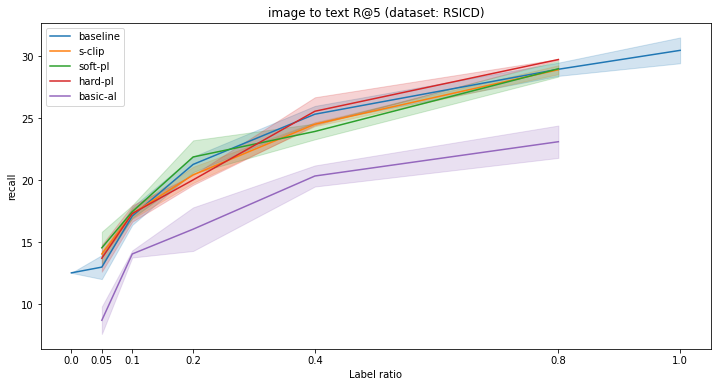

baseline image_to_text_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
6106       0.0     NaN  64     UCM      0  0.00005  image_to_text_R@5   base   
8086      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   base   
8087      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   base   
8088      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   base   
8089      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   base   
8090      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   base   
8091      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
6106  None   False  0.00  29.520  0.000000     2  
8086  None   False  0.05  34.954  1.704444     5  
8087  None   False  0.10  39.810  3.220877     5  
8088  None   False  0.20  48.286  2.395074     5  
8089  None   False  0.40  52.000  2.412955     5  
8090  None   False  0.80  55.716  1.784637     5  
8091  None   False  1.00  58.384  1.562380     5

s-clip image_to_text_R@5 UCM


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
11826      25.0     NaN  128     UCM     25  0.00005  image_to_text_R@5   
11827      25.0     NaN  128     UCM     25  0.00005  image_to_text_R@5   
11828      25.0     NaN  128     UCM     25  0.00005  image_to_text_R@5   
11829      25.0     NaN  128     UCM     25  0.00005  image_to_text_R@5   
11830      25.0     NaN  128     UCM     25  0.00005  image_to_text_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
11826   ours  ot.image   False  0.05  36.092  2.085454     5  
11827   ours  ot.image   False  0.10  42.478  0.854178     5  
11828   ours  ot.image   False  0.20  50.474  1.064368     5  
11829   ours  ot.image   False  0.40  49.052  2.128737     5  
11830   ours  ot.image   False  0.80  59.050  2.936614     5

soft-pl image_to_text_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
8292      30.0     NaN  64     UCM     30  0.00005  image_to_text_R@5   ours   
8293      30.0     NaN  64     UCM     30  0.00005  image_to_text_R@5   ours   
8294      30.0     NaN  64     UCM     30  0.00005  image_to_text_R@5   ours   
8295      30.0     NaN  64     UCM     30  0.00005  image_to_text_R@5   ours   
8296      30.0     NaN  64     UCM     30  0.00005  image_to_text_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8292  soft.text   False  0.05  37.334  1.737910     5  
8293  soft.text   False  0.10  40.286  3.309151     5  
8294  soft.text   False  0.20  47.240  2.743866     5  
8295  soft.text   False  0.40  52.952  3.537438     5  
8296  soft.text   False  0.80  55.428  1.043417     5

hard-pl image_to_text_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
8092      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   ours   
8093      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   ours   
8094      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   ours   
8095      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   ours   
8096      25.0     NaN  64     UCM     25  0.00005  image_to_text_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8092  hard.text   False  0.05  35.622  4.884902     5  
8093  hard.text   False  0.10  42.760  1.915568     5  
8094  hard.text   False  0.20  47.810  3.423543     5  
8095  hard.text   False  0.40  54.666  3.020576     5  
8096  hard.text   False  0.80  57.052  2.343399     5

basic-al image_to_text_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
18       10.0     2.0  64     UCM     20  0.00005  image_to_text_R@5   base   
42       10.0     5.0  64     UCM     20  0.00005  image_to_text_R@5   base   
66       10.0    10.0  64     UCM     20  0.00005  image_to_text_R@5   base   
90       10.0    20.0  64     UCM     20  0.00005  image_to_text_R@5   base   
114      10.0    40.0  64     UCM     20  0.00005  image_to_text_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
18   None   False  0.05  33.238  2.943802     5  
42   None   False  0.10  36.192  4.795667     5  
66   None   False  0.20  44.762  3.704918     5  
90   None   False  0.40  49.240  1.040673     5  
114  None   False  0.80  52.952  0.783243     5

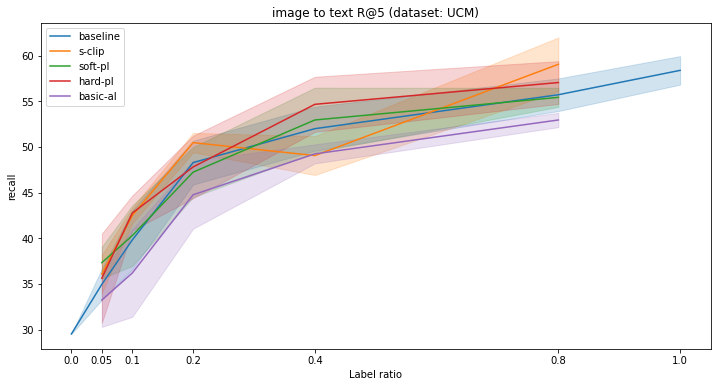

baseline image_to_text_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3862       0.0     NaN  64  Sydney      0  0.00005  image_to_text_R@5   base   
5842      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   base   
5843      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   base   
5844      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   base   
5845      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   base   
5846      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   base   
5847      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
3862  None   False  0.00   7.040  0.000000     2  
5842  None   False  0.05   9.498  1.629193     5  
5843  None   False  0.10  10.944  1.842099     5  
5844  None   False  0.20  15.454  1.396954     5  
5845  None   False  0.40  25.954  1.208338     5  
5846  None   False  0.80  39.274  1.375384     5  
5847  None   False  1.00  38.270  1.289981     5

s-clip image_to_text_R@5 Sydney


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
11076      25.0     NaN  128  Sydney     25  0.00005  image_to_text_R@5   
11077      25.0     NaN  128  Sydney     25  0.00005  image_to_text_R@5   
11078      25.0     NaN  128  Sydney     25  0.00005  image_to_text_R@5   
11079      25.0     NaN  128  Sydney     25  0.00005  image_to_text_R@5   
11080      25.0     NaN  128  Sydney     25  0.00005  image_to_text_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
11076   ours  ot.image   False  0.05   9.940  0.862583     5  
11077   ours  ot.image   False  0.10  11.748  0.720014     5  
11078   ours  ot.image   False  0.20  13.120  0.089443     5  
11079   ours  ot.image   False  0.40  19.152  0.093915     5  
11080   ours  ot.image   False  0.80  31.268  1.657564     5

soft-pl image_to_text_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
6048      30.0     NaN  64  Sydney     30  0.00005  image_to_text_R@5   ours   
6049      30.0     NaN  64  Sydney     30  0.00005  image_to_text_R@5   ours   
6050      30.0     NaN  64  Sydney     30  0.00005  image_to_text_R@5   ours   
6051      30.0     NaN  64  Sydney     30  0.00005  image_to_text_R@5   ours   
6052      30.0     NaN  64  Sydney     30  0.00005  image_to_text_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
6048  soft.text   False  0.05   9.294  0.846540     5  
6049  soft.text   False  0.10  10.786  1.423808     5  
6050  soft.text   False  0.20  14.526  0.929774     5  
6051  soft.text   False  0.40  19.920  1.479223     5  
6052  soft.text   False  0.80  27.928  1.676595     5

hard-pl image_to_text_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
5848      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   ours   
5849      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   ours   
5850      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   ours   
5851      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   ours   
5852      25.0     NaN  64  Sydney     25  0.00005  image_to_text_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
5848  hard.text   False  0.05   9.900  0.822830     5  
5849  hard.text   False  0.10  11.548  1.408020     5  
5850  hard.text   False  0.20  12.234  1.341801     5  
5851  hard.text   False  0.40  18.390  1.413895     5  
5852  hard.text   False  0.80  24.706  1.712828     5

basic-al image_to_text_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
12       10.0     2.0  64  Sydney     20  0.00005  image_to_text_R@5   base   
36       10.0     5.0  64  Sydney     20  0.00005  image_to_text_R@5   base   
60       10.0    10.0  64  Sydney     20  0.00005  image_to_text_R@5   base   
84       10.0    20.0  64  Sydney     20  0.00005  image_to_text_R@5   base   
108      10.0    40.0  64  Sydney     20  0.00005  image_to_text_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
12   None   False  0.05   6.638  1.357229     5  
36   None   False  0.10  10.540  0.268328     5  
60   None   False  0.20  14.370  4.299622     5  
84   None   False  0.40  21.528  2.755044     5  
108  None   False  0.80  31.872  0.996855     5

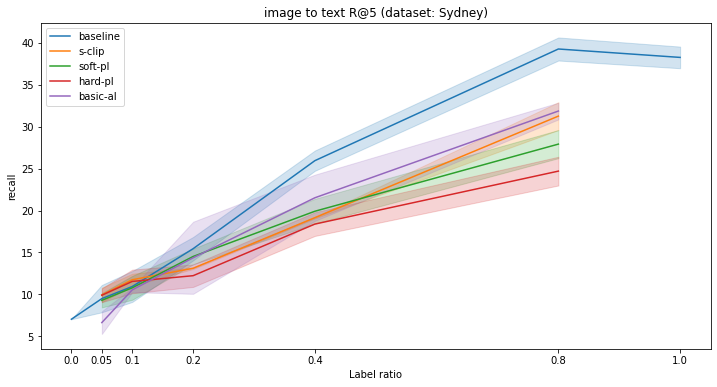

baseline text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
873        0.0     NaN  64   RSICD      0  0.00005  text_to_image_R@5   base   
2898      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2899      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2900      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2901      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2902      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2903      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
873   None   False  0.00  14.270  0.000000     2  
2898  None   False  0.05  13.122  0.420678     5  
2899  None   False  0.10  16.690  0.939920     5  
2900  None   False  0.20  20.806  1.018052     5  
2901  None   False  0.40  24.904  0.638968     5  
2902  None   False  0.80  29.532  0.979525     5  
2903  None   False  1.00  31.070  1.026913     5

s-clip text_to_image_R@5 RSICD


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
10091      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10092      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10093      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10094      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10095      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
10091   ours  ot.image   False  0.05  13.924  0.474847     5  
10092   ours  ot.image   False  0.10  17.196  0.818401     5  
10093   ours  ot.image   False  0.20  19.978  0.286217     5  
10094   ours  ot.image   False  0.40  23.462  0.898899     5  
10095   ours  ot.image   False  0.80  28.968  0.733430     5

soft-pl text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3083      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3084      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3085      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3086      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3087      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
3083  soft.text   False  0.05  14.638  0.614549     5  
3084  soft.text   False  0.10  18.152  0.697653     5  
3085  soft.text   False  0.20  22.234  1.206764     5  
3086  soft.text   False  0.40  25.712  0.497112     5  
3087  soft.text   False  0.80  30.062  1.053551     5

hard-pl text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
2904      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2905      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2906      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2907      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2908      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
2904  hard.text   False  0.05  13.630  0.606795     5  
2905  hard.text   False  0.10  17.988  1.053812     5  
2906  hard.text   False  0.20  20.258  0.612021     5  
2907  hard.text   False  0.40  25.616  0.849723     5  
2908  hard.text   False  0.80  30.248  0.532184     5

basic-al text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
7        10.0     2.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
31       10.0     5.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
55       10.0    10.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
79       10.0    20.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
103      10.0    40.0  64   RSICD     20  0.00005  text_to_image_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
7    None   False  0.05   8.324  1.836608     5  
31   None   False  0.10  12.422  0.075299     5  
55   None   False  0.20  15.830  1.833548     5  
79   None   False  0.40  20.806  1.456942     5  
103  None   False  0.80  24.210  0.301247     5

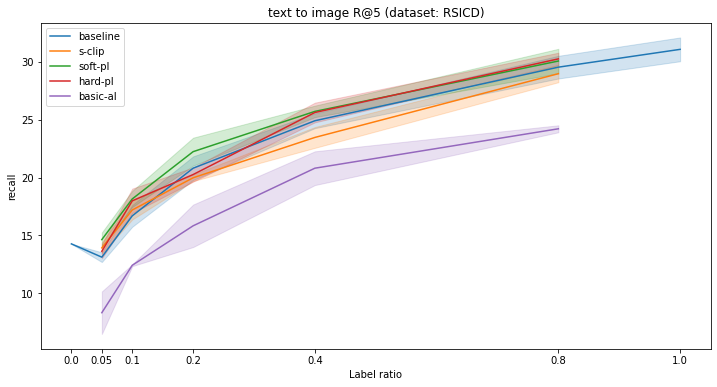

baseline text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
6109       0.0     NaN  64     UCM      0  0.00005  text_to_image_R@5   base   
8134      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8135      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8136      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8137      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8138      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8139      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
6109  None   False  0.00  31.430  0.000000     2  
8134  None   False  0.05  35.142  3.341118     5  
8135  None   False  0.10  38.096  1.814657     5  
8136  None   False  0.20  48.666  1.033697     5  
8137  None   False  0.40  50.666  1.735578     5  
8138  None   False  0.80  55.334  1.824179     5  
8139  None   False  1.00  59.714  2.558062     5

s-clip text_to_image_R@5 UCM


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
11841      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11842      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11843      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11844      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11845      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
11841   ours  ot.image   False  0.05  36.096  1.829393     5  
11842   ours  ot.image   False  0.10  43.140  0.424853     5  
11843   ours  ot.image   False  0.20  52.950  0.849706     5  
11844   ours  ot.image   False  0.40  51.900  0.000000     5  
11845   ours  ot.image   False  0.80  58.854  1.489221     5

soft-pl text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
8319      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8320      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8321      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8322      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8323      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8319  soft.text   False  0.05  38.192  3.292107     5  
8320  soft.text   False  0.10  42.476  1.362289     5  
8321  soft.text   False  0.20  46.474  0.926974     5  
8322  soft.text   False  0.40  52.188  1.192841     5  
8323  soft.text   False  0.80  57.618  1.431667     5

hard-pl text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
8140      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8141      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8142      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8143      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8144      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8140  hard.text   False  0.05  35.430  3.755210     5  
8141  hard.text   False  0.10  43.906  3.390403     5  
8142  hard.text   False  0.20  48.476  3.202246     5  
8143  hard.text   False  0.40  53.998  3.096784     5  
8144  hard.text   False  0.80  59.808  2.553590     5

basic-al text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
21       10.0     2.0  64     UCM     20  0.00005  text_to_image_R@5   base   
45       10.0     5.0  64     UCM     20  0.00005  text_to_image_R@5   base   
69       10.0    10.0  64     UCM     20  0.00005  text_to_image_R@5   base   
93       10.0    20.0  64     UCM     20  0.00005  text_to_image_R@5   base   
117      10.0    40.0  64     UCM     20  0.00005  text_to_image_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
21   None   False  0.05  33.428  1.915690     5  
45   None   False  0.10  39.046  1.064368     5  
69   None   False  0.20  42.856  1.344388     5  
93   None   False  0.40  48.666  3.127496     5  
117  None   False  0.80  52.858  1.303580     5

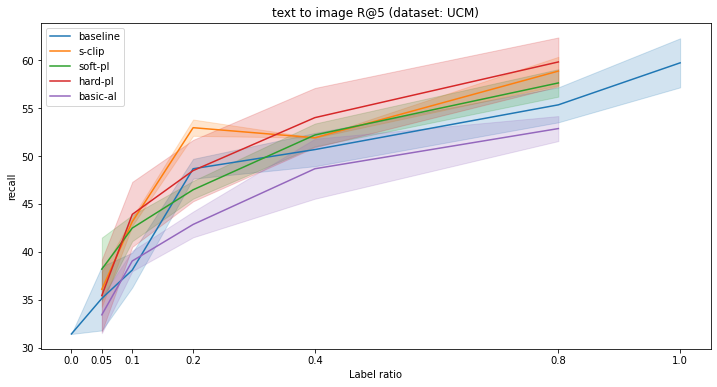

baseline text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3865       0.0     NaN  64  Sydney      0  0.00005  text_to_image_R@5   base   
5890      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5891      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5892      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5893      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5894      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5895      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
3865  None   False  0.00  10.660  0.000000     2  
5890  None   False  0.05  10.746  0.677370     5  
5891  None   False  0.10  14.406  1.293940     5  
5892  None   False  0.20  18.350  2.141775     5  
5893  None   False  0.40  27.044  1.087764     5  
5894  None   False  0.80  36.578  1.041091     5  
5895  None   False  1.00  37.666  0.438668     5

s-clip text_to_image_R@5 Sydney


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
11091      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11092      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11093      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11094      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11095      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
11091   ours  ot.image   False  0.05   9.742  1.077785     5  
11092   ours  ot.image   False  0.10  14.568  0.720014     5  
11093   ours  ot.image   False  0.20  17.140  0.357771     5  
11094   ours  ot.image   False  0.40  22.014  1.529470     5  
11095   ours  ot.image   False  0.80  31.710  0.178885     5

soft-pl text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
6075      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6076      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6077      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6078      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6079      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
6075  soft.text   False  0.05  11.146  2.197494     5  
6076  soft.text   False  0.10  12.714  1.453850     5  
6077  soft.text   False  0.20  17.382  0.719458     5  
6078  soft.text   False  0.40  20.806  1.218536     5  
6079  soft.text   False  0.80  27.848  0.442063     5

hard-pl text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
5896      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5897      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5898      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5899      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5900      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
5896  hard.text   False  0.05   9.656  0.752350     5  
5897  hard.text   False  0.10  12.876  0.493994     5  
5898  hard.text   False  0.20  16.016  0.848664     5  
5899  hard.text   False  0.40  21.328  1.865508     5  
5900  hard.text   False  0.80  26.200  0.089443     5

basic-al text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
15       10.0     2.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
39       10.0     5.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
63       10.0    10.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
87       10.0    20.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
111      10.0    40.0  64  Sydney     20  0.00005  text_to_image_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
15   None   False  0.05   8.250  0.648074     5  
39   None   False  0.10  10.464  1.797799     5  
63   None   False  0.20  16.096  4.025001     5  
87   None   False  0.40  21.324  3.855967     5  
111  None   False  0.80  33.122  1.763667     5

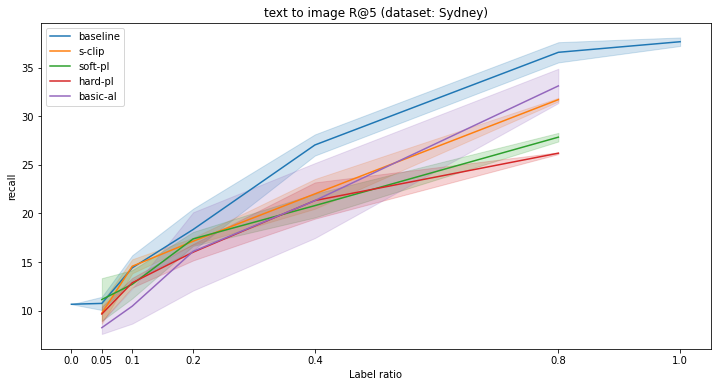

In [19]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['RSICD', 'UCM', 'Sydney']
for metric in metrics:
    for dataset in datasets:
        plot_model_comparison(results_dict, metric, dataset)

RSICD-CLS zeroshot-val-top1
baseline zeroshot-val-top1 RSICD-CLS


AL.epochs AL.iter  bs    dataset epochs       lr             metric  \
                                                                           
3112       0.0     NaN  64  RSICD-CLS      0  0.00005  zeroshot-val-top1   
3437      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3438      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3439      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3440      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3441      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3442      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   

     method    PL ProbVLM ratio   value                  
                                   mean       std count  
3112   base  None   False  0.00  53.710  0.000000     3  
3437   base  None   False  0.05  56.652  1.917008     5  
3438   base  None   False  0.10  63.916  1.673090     5  
3439   base  None   False  0.20  72.700  1.399071     5  
3440   base  None   False  0.40  83.220  1.070047     5  
3441   base  None   False  0.80  84.592  2.209835     5  
3442   base  None   False  1.00  85.142  1.542359     5

s-clip zeroshot-val-top1 RSICD-CLS


AL.epochs AL.iter   bs    dataset epochs       lr             metric  \
                                                                             
10216      25.0     NaN  128  RSICD-CLS     25  0.00005  zeroshot-val-top1   
10217      25.0     NaN  128  RSICD-CLS     25  0.00005  zeroshot-val-top1   
10218      25.0     NaN  128  RSICD-CLS     25  0.00005  zeroshot-val-top1   
10219      25.0     NaN  128  RSICD-CLS     25  0.00005  zeroshot-val-top1   
10220      25.0     NaN  128  RSICD-CLS     25  0.00005  zeroshot-val-top1   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
10216   ours  ot.image   False  0.05  55.884  1.488247     5  
10217   ours  ot.image   False  0.10  64.828  2.128737     5  
10218   ours  ot.image   False  0.20  77.950  1.229837     5  
10219   ours  ot.image   False  0.40  85.580  0.939149     5  
10220   ours  ot.image   False  0.80  86.732  1.024119     5

soft-pl zeroshot-val-top1 RSICD-CLS


AL.epochs AL.iter  bs    dataset epochs       lr             metric  \
                                                                           
3477      30.0     NaN  64  RSICD-CLS     30  0.00005  zeroshot-val-top1   
3478      30.0     NaN  64  RSICD-CLS     30  0.00005  zeroshot-val-top1   
3479      30.0     NaN  64  RSICD-CLS     30  0.00005  zeroshot-val-top1   
3480      30.0     NaN  64  RSICD-CLS     30  0.00005  zeroshot-val-top1   
3481      30.0     NaN  64  RSICD-CLS     30  0.00005  zeroshot-val-top1   

     method         PL ProbVLM ratio   value                  
                                        mean       std count  
3477   ours  soft.text   False  0.05  57.108  1.777645     5  
3478   ours  soft.text   False  0.10  63.640  0.868188     5  
3479   ours  soft.text   False  0.20  77.016  1.222448     5  
3480   ours  soft.text   False  0.40  83.168  2.388874     5  
3481   ours  soft.text   False  0.80  88.748  0.948061     5

hard-pl zeroshot-val-top1 RSICD-CLS


AL.epochs AL.iter  bs    dataset epochs       lr             metric  \
                                                                           
3443      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3444      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3445      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3446      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   
3447      25.0     NaN  64  RSICD-CLS     25  0.00005  zeroshot-val-top1   

     method         PL ProbVLM ratio   value                  
                                        mean       std count  
3443   ours  hard.text   False  0.05  59.012  1.691204     5  
3444   ours  hard.text   False  0.10  65.214  2.675253     5  
3445   ours  hard.text   False  0.20  75.314  0.452526     5  
3446   ours  hard.text   False  0.40  82.086  2.044170     5  
3447   ours  hard.text   False  0.80  84.888  0.979398     5

basic-al zeroshot-val-top1 RSICD-CLS


AL.epochs AL.iter  bs    dataset epochs       lr             metric  \
                                                                          
8        10.0     2.0  64  RSICD-CLS     20  0.00005  zeroshot-val-top1   
32       10.0     5.0  64  RSICD-CLS     20  0.00005  zeroshot-val-top1   
56       10.0    10.0  64  RSICD-CLS     20  0.00005  zeroshot-val-top1   
80       10.0    20.0  64  RSICD-CLS     20  0.00005  zeroshot-val-top1   
104      10.0    40.0  64  RSICD-CLS     20  0.00005  zeroshot-val-top1   

    method    PL ProbVLM ratio   value                  
                                  mean       std count  
8     base  None   False  0.05  42.434  2.685280     5  
32    base  None   False  0.10  57.002  3.735555     5  
56    base  None   False  0.20  62.452  7.301234     5  
80    base  None   False  0.40  71.418  3.708082     5  
104   base  None   False  0.80  78.776  1.500760     5

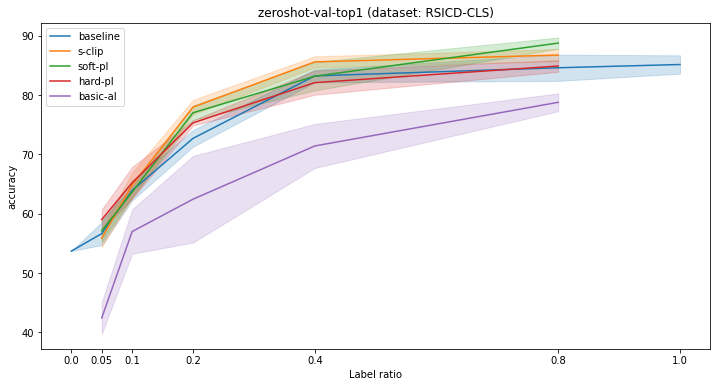

UCM-CLS zeroshot-val-top1
baseline zeroshot-val-top1 UCM-CLS


AL.epochs AL.iter  bs  dataset epochs       lr             metric method  \
                                                                                
8348       0.0     NaN  64  UCM-CLS      0  0.00005  zeroshot-val-top1   base   
8673      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   base   
8674      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   base   
8675      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   base   
8676      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   base   
8677      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   base   
8678      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   base   

        PL ProbVLM ratio   value                      
                            mean           std count  
8348  None   False  0.00  49.050  8.702336e-15     3  
8673  None   False  0.05  53.332  2.104904e+00     5  
8674  None   False  0.10  57.712  1.974062e+00     5  
8675  None   False  0.20  68.476  1.361591e+00     5  
8676  None   False  0.40  71.238  2.924691e+00     5  
8677  None   False  0.80  76.284  1.827438e+00     5  
8678  None   False  1.00  68.666  3.150775e+00     5

s-clip zeroshot-val-top1 UCM-CLS


AL.epochs AL.iter   bs  dataset epochs       lr             metric  \
                                                                           
11966      25.0     NaN  128  UCM-CLS     25  0.00005  zeroshot-val-top1   
11967      25.0     NaN  128  UCM-CLS     25  0.00005  zeroshot-val-top1   
11968      25.0     NaN  128  UCM-CLS     25  0.00005  zeroshot-val-top1   
11969      25.0     NaN  128  UCM-CLS     25  0.00005  zeroshot-val-top1   
11970      25.0     NaN  128  UCM-CLS     25  0.00005  zeroshot-val-top1   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
11966   ours  ot.image   False  0.05  57.904  1.046150     5  
11967   ours  ot.image   False  0.10  63.618  1.192841     5  
11968   ours  ot.image   False  0.20  70.384  0.214663     5  
11969   ours  ot.image   False  0.40  68.760  0.424853     5  
11970   ours  ot.image   False  0.80  73.426  0.214663     5

soft-pl zeroshot-val-top1 UCM-CLS


AL.epochs AL.iter  bs  dataset epochs       lr             metric method  \
                                                                                
8713      30.0     NaN  64  UCM-CLS     30  0.00005  zeroshot-val-top1   ours   
8714      30.0     NaN  64  UCM-CLS     30  0.00005  zeroshot-val-top1   ours   
8715      30.0     NaN  64  UCM-CLS     30  0.00005  zeroshot-val-top1   ours   
8716      30.0     NaN  64  UCM-CLS     30  0.00005  zeroshot-val-top1   ours   
8717      30.0     NaN  64  UCM-CLS     30  0.00005  zeroshot-val-top1   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8713  soft.text   False  0.05  53.812  2.104904     5  
8714  soft.text   False  0.10  62.762  3.523283     5  
8715  soft.text   False  0.20  71.716  0.639515     5  
8716  soft.text   False  0.40  73.142  0.986671     5  
8717  soft.text   False  0.80  73.618  2.170500     5

hard-pl zeroshot-val-top1 UCM-CLS


AL.epochs AL.iter  bs  dataset epochs       lr             metric method  \
                                                                                
8679      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   ours   
8680      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   ours   
8681      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   ours   
8682      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   ours   
8683      25.0     NaN  64  UCM-CLS     25  0.00005  zeroshot-val-top1   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8679  hard.text   False  0.05  51.618  5.267326     5  
8680  hard.text   False  0.10  62.948  2.702086     5  
8681  hard.text   False  0.20  67.906  2.513102     5  
8682  hard.text   False  0.40  73.904  3.707024     5  
8683  hard.text   False  0.80  69.716  1.489221     5

basic-al zeroshot-val-top1 UCM-CLS


AL.epochs AL.iter  bs  dataset epochs       lr             metric method  \
                                                                               
22       10.0     2.0  64  UCM-CLS     20  0.00005  zeroshot-val-top1   base   
46       10.0     5.0  64  UCM-CLS     20  0.00005  zeroshot-val-top1   base   
70       10.0    10.0  64  UCM-CLS     20  0.00005  zeroshot-val-top1   base   
94       10.0    20.0  64  UCM-CLS     20  0.00005  zeroshot-val-top1   base   
118      10.0    40.0  64  UCM-CLS     20  0.00005  zeroshot-val-top1   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
22   None   False  0.05  54.952  3.381016     5  
46   None   False  0.10  55.906  4.686798     5  
70   None   False  0.20  63.806  1.782633     5  
94   None   False  0.40  65.998  3.653309     5  
118  None   False  0.80  72.188  3.653309     5

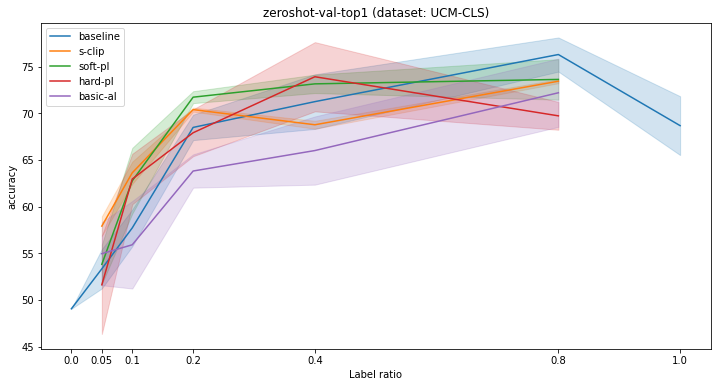

WHU-RS19 zeroshot-val-top1
baseline zeroshot-val-top1 WHU-RS19


AL.epochs AL.iter  bs   dataset epochs       lr             metric  \
                                                                          
8722       0.0     NaN  64  WHU-RS19      0  0.00005  zeroshot-val-top1   
9047      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9048      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9049      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9050      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9051      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9052      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   

     method    PL ProbVLM ratio   value                  
                                   mean       std count  
8722   base  None   False  0.00  68.560  0.000000     3  
9047   base  None   False  0.05  72.816  2.298027     5  
9048   base  None   False  0.10  81.810  1.640290     5  
9049   base  None   False  0.20  86.944  2.460961     5  
9050   base  None   False  0.40  93.252  0.540759     5  
9051   base  None   False  0.80  94.926  0.692120     5  
9052   base  None   False  1.00  93.032  0.500520     5

s-clip zeroshot-val-top1 WHU-RS19


AL.epochs AL.iter   bs   dataset epochs       lr             metric  \
                                                                            
12091      25.0     NaN  128  WHU-RS19     25  0.00005  zeroshot-val-top1   
12092      25.0     NaN  128  WHU-RS19     25  0.00005  zeroshot-val-top1   
12093      25.0     NaN  128  WHU-RS19     25  0.00005  zeroshot-val-top1   
12094      25.0     NaN  128  WHU-RS19     25  0.00005  zeroshot-val-top1   
12095      25.0     NaN  128  WHU-RS19     25  0.00005  zeroshot-val-top1   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
12091   ours  ot.image   False  0.05  76.776  1.231109     5  
12092   ours  ot.image   False  0.10  84.932  0.979398     5  
12093   ours  ot.image   False  0.20  87.784  2.714587     5  
12094   ours  ot.image   False  0.40  95.780  0.134164     5  
12095   ours  ot.image   False  0.80  96.678  0.353299     5

soft-pl zeroshot-val-top1 WHU-RS19


AL.epochs AL.iter  bs   dataset epochs       lr             metric  \
                                                                          
9087      30.0     NaN  64  WHU-RS19     30  0.00005  zeroshot-val-top1   
9088      30.0     NaN  64  WHU-RS19     30  0.00005  zeroshot-val-top1   
9089      30.0     NaN  64  WHU-RS19     30  0.00005  zeroshot-val-top1   
9090      30.0     NaN  64  WHU-RS19     30  0.00005  zeroshot-val-top1   
9091      30.0     NaN  64  WHU-RS19     30  0.00005  zeroshot-val-top1   

     method         PL ProbVLM ratio   value                  
                                        mean       std count  
9087   ours  soft.text   False  0.05  77.570  1.490822     5  
9088   ours  soft.text   False  0.10  83.282  3.577467     5  
9089   ours  soft.text   False  0.20  91.882  1.660548     5  
9090   ours  soft.text   False  0.40  95.680  0.313050     5  
9091   ours  soft.text   False  0.80  96.734  0.760809     5

hard-pl zeroshot-val-top1 WHU-RS19


AL.epochs AL.iter  bs   dataset epochs       lr             metric  \
                                                                          
9053      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9054      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9055      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9056      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   
9057      25.0     NaN  64  WHU-RS19     25  0.00005  zeroshot-val-top1   

     method         PL ProbVLM ratio   value                  
                                        mean       std count  
9053   ours  hard.text   False  0.05  76.616  3.076244     5  
9054   ours  hard.text   False  0.10  84.160  1.241813     5  
9055   ours  hard.text   False  0.20  91.182  1.490107     5  
9056   ours  hard.text   False  0.40  93.534  0.952119     5  
9057   ours  hard.text   False  0.80  97.134  1.287975     5

basic-al zeroshot-val-top1 WHU-RS19


AL.epochs AL.iter  bs   dataset epochs       lr             metric method  \
                                                                                
23       10.0     2.0  64  WHU-RS19     20  0.00005  zeroshot-val-top1   base   
47       10.0     5.0  64  WHU-RS19     20  0.00005  zeroshot-val-top1   base   
71       10.0    10.0  64  WHU-RS19     20  0.00005  zeroshot-val-top1   base   
95       10.0    20.0  64  WHU-RS19     20  0.00005  zeroshot-val-top1   base   
119      10.0    40.0  64  WHU-RS19     20  0.00005  zeroshot-val-top1   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
23   None   False  0.05  57.352  4.002408     5  
47   None   False  0.10  70.686  2.133209     5  
71   None   False  0.20  79.364  3.575735     5  
95   None   False  0.40  84.456  0.925651     5  
119  None   False  0.80  88.776  1.254285     5

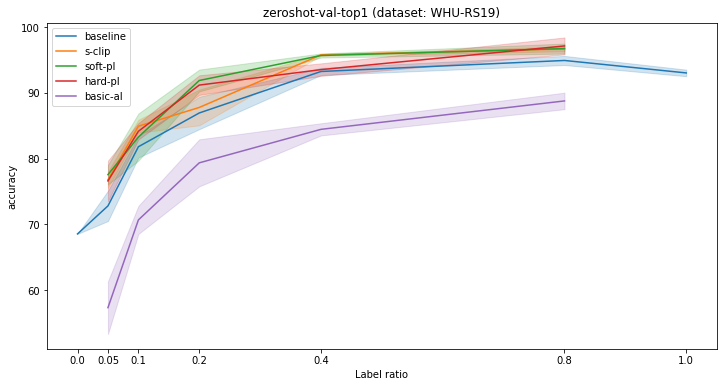

RSSCN7 zeroshot-val-top1
baseline zeroshot-val-top1 RSSCN7


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3486       0.0     NaN  64  RSSCN7      0  0.00005  zeroshot-val-top1   base   
3811      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   base   
3812      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   base   
3813      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   base   
3814      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   base   
3815      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   base   
3816      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
3486  None   False  0.00  55.000  0.000000     3  
3811  None   False  0.05  54.836  1.017561     5  
3812  None   False  0.10  63.492  3.774284     5  
3813  None   False  0.20  65.036  1.538597     5  
3814  None   False  0.40  64.236  2.246526     5  
3815  None   False  0.80  66.378  3.602835     5  
3816  None   False  1.00  66.872  1.670500     5

s-clip zeroshot-val-top1 RSSCN7


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
10341      25.0     NaN  128  RSSCN7     25  0.00005  zeroshot-val-top1   
10342      25.0     NaN  128  RSSCN7     25  0.00005  zeroshot-val-top1   
10343      25.0     NaN  128  RSSCN7     25  0.00005  zeroshot-val-top1   
10344      25.0     NaN  128  RSSCN7     25  0.00005  zeroshot-val-top1   
10345      25.0     NaN  128  RSSCN7     25  0.00005  zeroshot-val-top1   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
10341   ours  ot.image   False  0.05  57.146  3.059490     5  
10342   ours  ot.image   False  0.10  59.454  0.143108     5  
10343   ours  ot.image   False  0.20  66.004  3.049997     5  
10344   ours  ot.image   False  0.40  59.682  2.173458     5  
10345   ours  ot.image   False  0.80  66.902  0.465102     5

soft-pl zeroshot-val-top1 RSSCN7


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3851      30.0     NaN  64  RSSCN7     30  0.00005  zeroshot-val-top1   ours   
3852      30.0     NaN  64  RSSCN7     30  0.00005  zeroshot-val-top1   ours   
3853      30.0     NaN  64  RSSCN7     30  0.00005  zeroshot-val-top1   ours   
3854      30.0     NaN  64  RSSCN7     30  0.00005  zeroshot-val-top1   ours   
3855      30.0     NaN  64  RSSCN7     30  0.00005  zeroshot-val-top1   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
3851  soft.text   False  0.05  58.644  4.783020     5  
3852  soft.text   False  0.10  62.436  1.606200     5  
3853  soft.text   False  0.20  65.830  2.353657     5  
3854  soft.text   False  0.40  67.864  1.889704     5  
3855  soft.text   False  0.80  64.800  2.345666     5

hard-pl zeroshot-val-top1 RSSCN7


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3817      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   ours   
3818      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   ours   
3819      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   ours   
3820      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   ours   
3821      25.0     NaN  64  RSSCN7     25  0.00005  zeroshot-val-top1   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
3817  hard.text   False  0.05  56.786  3.571733     5  
3818  hard.text   False  0.10  58.944  1.496489     5  
3819  hard.text   False  0.20  64.956  3.422306     5  
3820  hard.text   False  0.40  66.790  1.980795     5  
3821  hard.text   False  0.80  64.002  0.720014     5

basic-al zeroshot-val-top1 RSSCN7


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
9        10.0     2.0  64  RSSCN7     20  0.00005  zeroshot-val-top1   base   
33       10.0     5.0  64  RSSCN7     20  0.00005  zeroshot-val-top1   base   
57       10.0    10.0  64  RSSCN7     20  0.00005  zeroshot-val-top1   base   
81       10.0    20.0  64  RSSCN7     20  0.00005  zeroshot-val-top1   base   
105      10.0    40.0  64  RSSCN7     20  0.00005  zeroshot-val-top1   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
9    None   False  0.05  51.362  1.423032     5  
33   None   False  0.10  62.174  2.590652     5  
57   None   False  0.20  61.194  2.826974     5  
81   None   False  0.40  57.972  1.330966     5  
105  None   False  0.80  60.122  3.247995     5

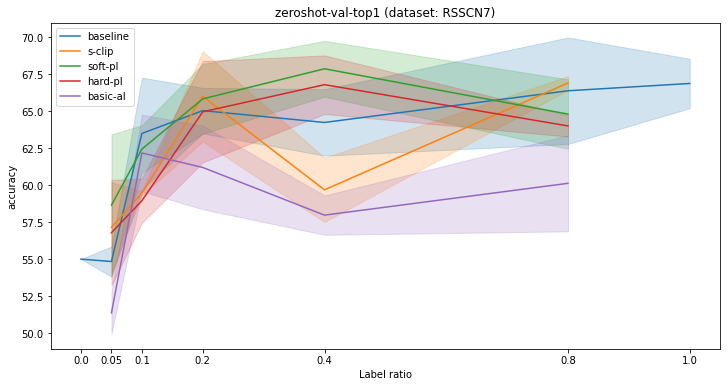

AID zeroshot-val-top1
baseline zeroshot-val-top1 AID


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
120       0.0     NaN  64     AID      0  0.00005  zeroshot-val-top1   base   
445      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   base   
446      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   base   
447      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   base   
448      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   base   
449      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   base   
450      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
120  None   False  0.00  52.820  0.000000     2  
445  None   False  0.05  61.106  2.422329     5  
446  None   False  0.10  68.166  1.051038     5  
447  None   False  0.20  77.632  1.239706     5  
448  None   False  0.40  86.402  1.271739     5  
449  None   False  0.80  89.808  0.570500     5  
450  None   False  1.00  87.698  2.225774     5

s-clip zeroshot-val-top1 AID


AL.epochs AL.iter   bs dataset epochs       lr             metric method  \
                                                                                
9216      25.0     NaN  128     AID     25  0.00005  zeroshot-val-top1   ours   
9217      25.0     NaN  128     AID     25  0.00005  zeroshot-val-top1   ours   
9218      25.0     NaN  128     AID     25  0.00005  zeroshot-val-top1   ours   
9219      25.0     NaN  128     AID     25  0.00005  zeroshot-val-top1   ours   
9220      25.0     NaN  128     AID     25  0.00005  zeroshot-val-top1   ours   

            PL ProbVLM ratio   value                  
                                mean       std count  
9216  ot.image   False  0.05  60.780  1.260674     5  
9217  ot.image   False  0.10  71.688  0.764735     5  
9218  ot.image   False  0.20  81.980  0.201246     5  
9219  ot.image   False  0.40  90.080  0.916788     5  
9220  ot.image   False  0.80  91.262  0.152053     5

soft-pl zeroshot-val-top1 AID


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
485      30.0     NaN  64     AID     30  0.00005  zeroshot-val-top1   ours   
486      30.0     NaN  64     AID     30  0.00005  zeroshot-val-top1   ours   
487      30.0     NaN  64     AID     30  0.00005  zeroshot-val-top1   ours   
488      30.0     NaN  64     AID     30  0.00005  zeroshot-val-top1   ours   
489      30.0     NaN  64     AID     30  0.00005  zeroshot-val-top1   ours   

            PL ProbVLM ratio   value                  
                                mean       std count  
485  soft.text   False  0.05  61.662  1.410805     5  
486  soft.text   False  0.10  71.476  1.230114     5  
487  soft.text   False  0.20  83.206  0.878282     5  
488  soft.text   False  0.40  88.418  1.586591     5  
489  soft.text   False  0.80  92.858  0.868372     5

hard-pl zeroshot-val-top1 AID


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
451      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   ours   
452      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   ours   
453      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   ours   
454      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   ours   
455      25.0     NaN  64     AID     25  0.00005  zeroshot-val-top1   ours   

            PL ProbVLM ratio   value                  
                                mean       std count  
451  hard.text   False  0.05  62.148  1.000335     5  
452  hard.text   False  0.10  71.790  0.514296     5  
453  hard.text   False  0.20  81.180  0.213307     5  
454  hard.text   False  0.40  87.206  1.901534     5  
455  hard.text   False  0.80  90.238  0.787096     5

basic-al zeroshot-val-top1 AID


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                             
0       10.0     2.0  64     AID     20  0.00005  zeroshot-val-top1   base   
24      10.0     5.0  64     AID     20  0.00005  zeroshot-val-top1   base   
48      10.0    10.0  64     AID     20  0.00005  zeroshot-val-top1   base   
72      10.0    20.0  64     AID     20  0.00005  zeroshot-val-top1   base   
96      10.0    40.0  64     AID     20  0.00005  zeroshot-val-top1   base   

      PL ProbVLM ratio   value                  
                          mean       std count  
0   None   False  0.05  41.808  3.546022     5  
24  None   False  0.10  58.554  4.111032     5  
48  None   False  0.20  65.626  5.568454     5  
72  None   False  0.40  75.212  5.137638     5  
96  None   False  0.80  81.850  1.177603     5

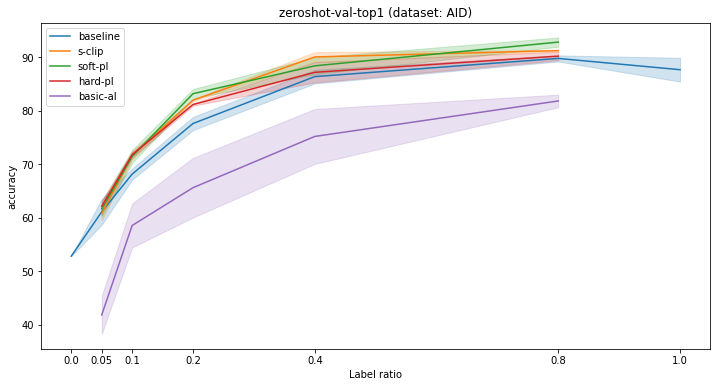

RESISC45 zeroshot-val-top1
baseline zeroshot-val-top1 RESISC45


AL.epochs AL.iter  bs   dataset epochs       lr             metric method  \
                                                                                
494       0.0     NaN  64  RESISC45      0  0.00005  zeroshot-val-top1   base   
819      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   base   
820      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   base   
821      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   base   
822      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   base   
823      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   base   
824      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
494  None   False  0.00  48.710  0.000000     2  
819  None   False  0.05  31.408  1.490493     5  
820  None   False  0.10  32.692  1.019348     5  
821  None   False  0.20  38.208  1.053931     5  
822  None   False  0.40  40.236  1.704503     5  
823  None   False  0.80  43.876  1.197969     5  
824  None   False  1.00  45.844  0.564385     5

s-clip zeroshot-val-top1 RESISC45


AL.epochs AL.iter   bs   dataset epochs       lr             metric  \
                                                                           
9341      25.0     NaN  128  RESISC45     25  0.00005  zeroshot-val-top1   
9342      25.0     NaN  128  RESISC45     25  0.00005  zeroshot-val-top1   
9343      25.0     NaN  128  RESISC45     25  0.00005  zeroshot-val-top1   
9344      25.0     NaN  128  RESISC45     25  0.00005  zeroshot-val-top1   
9345      25.0     NaN  128  RESISC45     25  0.00005  zeroshot-val-top1   

     method        PL ProbVLM ratio   value                  
                                       mean       std count  
9341   ours  ot.image   False  0.05  31.670  0.645794     5  
9342   ours  ot.image   False  0.10  35.382  0.643988     5  
9343   ours  ot.image   False  0.20  42.808  1.748605     5  
9344   ours  ot.image   False  0.40  46.538  0.040249     5  
9345   ours  ot.image   False  0.80  49.022  1.957682     5

soft-pl zeroshot-val-top1 RESISC45


AL.epochs AL.iter  bs   dataset epochs       lr             metric method  \
                                                                                
859      30.0     NaN  64  RESISC45     30  0.00005  zeroshot-val-top1   ours   
860      30.0     NaN  64  RESISC45     30  0.00005  zeroshot-val-top1   ours   
861      30.0     NaN  64  RESISC45     30  0.00005  zeroshot-val-top1   ours   
862      30.0     NaN  64  RESISC45     30  0.00005  zeroshot-val-top1   ours   
863      30.0     NaN  64  RESISC45     30  0.00005  zeroshot-val-top1   ours   

            PL ProbVLM ratio   value                  
                                mean       std count  
859  soft.text   False  0.05  30.328  1.330233     5  
860  soft.text   False  0.10  36.942  2.449514     5  
861  soft.text   False  0.20  44.372  1.224978     5  
862  soft.text   False  0.40  45.820  1.336095     5  
863  soft.text   False  0.80  46.714  2.242338     5

hard-pl zeroshot-val-top1 RESISC45


AL.epochs AL.iter  bs   dataset epochs       lr             metric method  \
                                                                                
825      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   ours   
826      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   ours   
827      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   ours   
828      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   ours   
829      25.0     NaN  64  RESISC45     25  0.00005  zeroshot-val-top1   ours   

            PL ProbVLM ratio   value                  
                                mean       std count  
825  hard.text   False  0.05  29.532  1.536219     5  
826  hard.text   False  0.10  35.312  0.492818     5  
827  hard.text   False  0.20  40.044  1.627108     5  
828  hard.text   False  0.40  44.900  1.230406     5  
829  hard.text   False  0.80  45.998  0.375659     5

basic-al zeroshot-val-top1 RESISC45


AL.epochs AL.iter  bs   dataset epochs       lr             metric method  \
                                                                               
1       10.0     2.0  64  RESISC45     20  0.00005  zeroshot-val-top1   base   
25      10.0     5.0  64  RESISC45     20  0.00005  zeroshot-val-top1   base   
49      10.0    10.0  64  RESISC45     20  0.00005  zeroshot-val-top1   base   
73      10.0    20.0  64  RESISC45     20  0.00005  zeroshot-val-top1   base   
97      10.0    40.0  64  RESISC45     20  0.00005  zeroshot-val-top1   base   

      PL ProbVLM ratio   value                  
                          mean       std count  
1   None   False  0.05  22.062  2.054062     5  
25  None   False  0.10  28.878  0.493072     5  
49  None   False  0.20  32.034  3.995263     5  
73  None   False  0.40  36.426  2.322344     5  
97  None   False  0.80  39.226  0.432701     5

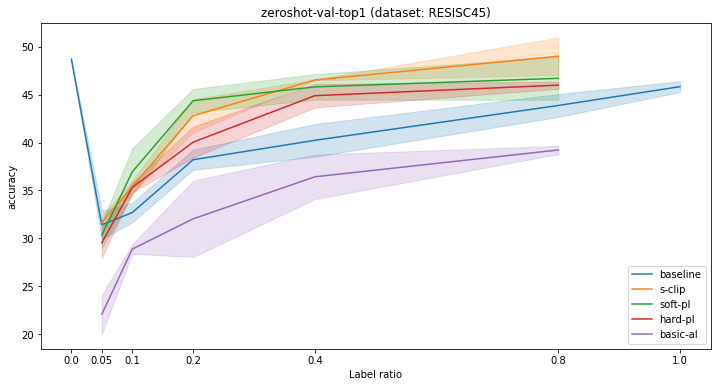

In [20]:
metric = 'zeroshot-val-top1'
datasets = ["RSICD-CLS", "UCM-CLS", "WHU-RS19", "RSSCN7", "AID", "RESISC45"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

baseline text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
873        0.0     NaN  64   RSICD      0  0.00005  text_to_image_R@5   base   
2898      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2899      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2900      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2901      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2902      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   
2903      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
873   None   False  0.00  14.270  0.000000     2  
2898  None   False  0.05  13.122  0.420678     5  
2899  None   False  0.10  16.690  0.939920     5  
2900  None   False  0.20  20.806  1.018052     5  
2901  None   False  0.40  24.904  0.638968     5  
2902  None   False  0.80  29.532  0.979525     5  
2903  None   False  1.00  31.070  1.026913     5

s-clip text_to_image_R@5 RSICD


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
10091      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10092      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10093      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10094      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   
10095      25.0     NaN  128   RSICD     25  0.00005  text_to_image_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
10091   ours  ot.image   False  0.05  13.924  0.474847     5  
10092   ours  ot.image   False  0.10  17.196  0.818401     5  
10093   ours  ot.image   False  0.20  19.978  0.286217     5  
10094   ours  ot.image   False  0.40  23.462  0.898899     5  
10095   ours  ot.image   False  0.80  28.968  0.733430     5

soft-pl text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3083      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3084      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3085      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3086      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   
3087      30.0     NaN  64   RSICD     30  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
3083  soft.text   False  0.05  14.638  0.614549     5  
3084  soft.text   False  0.10  18.152  0.697653     5  
3085  soft.text   False  0.20  22.234  1.206764     5  
3086  soft.text   False  0.40  25.712  0.497112     5  
3087  soft.text   False  0.80  30.062  1.053551     5

hard-pl text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
2904      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2905      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2906      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2907      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   
2908      25.0     NaN  64   RSICD     25  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
2904  hard.text   False  0.05  13.630  0.606795     5  
2905  hard.text   False  0.10  17.988  1.053812     5  
2906  hard.text   False  0.20  20.258  0.612021     5  
2907  hard.text   False  0.40  25.616  0.849723     5  
2908  hard.text   False  0.80  30.248  0.532184     5

basic-al text_to_image_R@5 RSICD


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
7        10.0     2.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
31       10.0     5.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
55       10.0    10.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
79       10.0    20.0  64   RSICD     20  0.00005  text_to_image_R@5   base   
103      10.0    40.0  64   RSICD     20  0.00005  text_to_image_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
7    None   False  0.05   8.324  1.836608     5  
31   None   False  0.10  12.422  0.075299     5  
55   None   False  0.20  15.830  1.833548     5  
79   None   False  0.40  20.806  1.456942     5  
103  None   False  0.80  24.210  0.301247     5

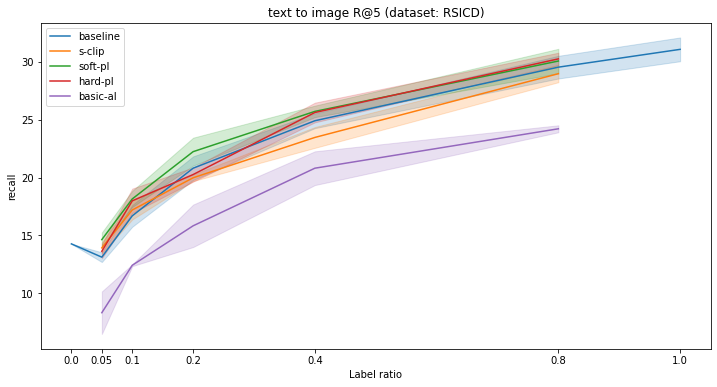

baseline text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
6109       0.0     NaN  64     UCM      0  0.00005  text_to_image_R@5   base   
8134      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8135      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8136      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8137      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8138      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   
8139      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
6109  None   False  0.00  31.430  0.000000     2  
8134  None   False  0.05  35.142  3.341118     5  
8135  None   False  0.10  38.096  1.814657     5  
8136  None   False  0.20  48.666  1.033697     5  
8137  None   False  0.40  50.666  1.735578     5  
8138  None   False  0.80  55.334  1.824179     5  
8139  None   False  1.00  59.714  2.558062     5

s-clip text_to_image_R@5 UCM


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
11841      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11842      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11843      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11844      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   
11845      25.0     NaN  128     UCM     25  0.00005  text_to_image_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
11841   ours  ot.image   False  0.05  36.096  1.829393     5  
11842   ours  ot.image   False  0.10  43.140  0.424853     5  
11843   ours  ot.image   False  0.20  52.950  0.849706     5  
11844   ours  ot.image   False  0.40  51.900  0.000000     5  
11845   ours  ot.image   False  0.80  58.854  1.489221     5

soft-pl text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
8319      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8320      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8321      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8322      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   
8323      30.0     NaN  64     UCM     30  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8319  soft.text   False  0.05  38.192  3.292107     5  
8320  soft.text   False  0.10  42.476  1.362289     5  
8321  soft.text   False  0.20  46.474  0.926974     5  
8322  soft.text   False  0.40  52.188  1.192841     5  
8323  soft.text   False  0.80  57.618  1.431667     5

hard-pl text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
8140      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8141      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8142      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8143      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   
8144      25.0     NaN  64     UCM     25  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
8140  hard.text   False  0.05  35.430  3.755210     5  
8141  hard.text   False  0.10  43.906  3.390403     5  
8142  hard.text   False  0.20  48.476  3.202246     5  
8143  hard.text   False  0.40  53.998  3.096784     5  
8144  hard.text   False  0.80  59.808  2.553590     5

basic-al text_to_image_R@5 UCM


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
21       10.0     2.0  64     UCM     20  0.00005  text_to_image_R@5   base   
45       10.0     5.0  64     UCM     20  0.00005  text_to_image_R@5   base   
69       10.0    10.0  64     UCM     20  0.00005  text_to_image_R@5   base   
93       10.0    20.0  64     UCM     20  0.00005  text_to_image_R@5   base   
117      10.0    40.0  64     UCM     20  0.00005  text_to_image_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
21   None   False  0.05  33.428  1.915690     5  
45   None   False  0.10  39.046  1.064368     5  
69   None   False  0.20  42.856  1.344388     5  
93   None   False  0.40  48.666  3.127496     5  
117  None   False  0.80  52.858  1.303580     5

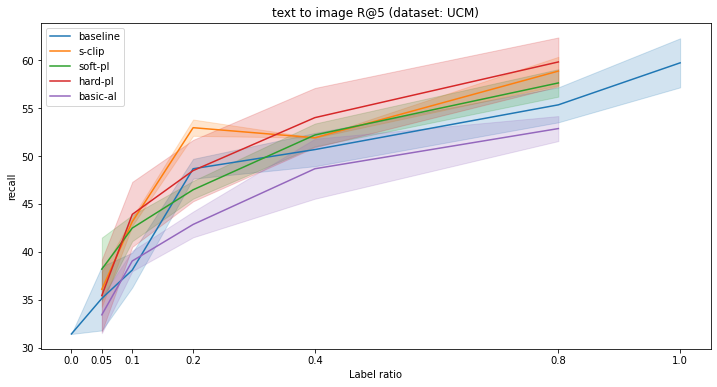

baseline text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
3865       0.0     NaN  64  Sydney      0  0.00005  text_to_image_R@5   base   
5890      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5891      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5892      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5893      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5894      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   
5895      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   base   

        PL ProbVLM ratio   value                  
                            mean       std count  
3865  None   False  0.00  10.660  0.000000     2  
5890  None   False  0.05  10.746  0.677370     5  
5891  None   False  0.10  14.406  1.293940     5  
5892  None   False  0.20  18.350  2.141775     5  
5893  None   False  0.40  27.044  1.087764     5  
5894  None   False  0.80  36.578  1.041091     5  
5895  None   False  1.00  37.666  0.438668     5

s-clip text_to_image_R@5 Sydney


AL.epochs AL.iter   bs dataset epochs       lr             metric  \
                                                                          
11091      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11092      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11093      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11094      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   
11095      25.0     NaN  128  Sydney     25  0.00005  text_to_image_R@5   

      method        PL ProbVLM ratio   value                  
                                        mean       std count  
11091   ours  ot.image   False  0.05   9.742  1.077785     5  
11092   ours  ot.image   False  0.10  14.568  0.720014     5  
11093   ours  ot.image   False  0.20  17.140  0.357771     5  
11094   ours  ot.image   False  0.40  22.014  1.529470     5  
11095   ours  ot.image   False  0.80  31.710  0.178885     5

soft-pl text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
6075      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6076      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6077      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6078      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   
6079      30.0     NaN  64  Sydney     30  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
6075  soft.text   False  0.05  11.146  2.197494     5  
6076  soft.text   False  0.10  12.714  1.453850     5  
6077  soft.text   False  0.20  17.382  0.719458     5  
6078  soft.text   False  0.40  20.806  1.218536     5  
6079  soft.text   False  0.80  27.848  0.442063     5

hard-pl text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                               
5896      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5897      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5898      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5899      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   
5900      25.0     NaN  64  Sydney     25  0.00005  text_to_image_R@5   ours   

             PL ProbVLM ratio   value                  
                                 mean       std count  
5896  hard.text   False  0.05   9.656  0.752350     5  
5897  hard.text   False  0.10  12.876  0.493994     5  
5898  hard.text   False  0.20  16.016  0.848664     5  
5899  hard.text   False  0.40  21.328  1.865508     5  
5900  hard.text   False  0.80  26.200  0.089443     5

basic-al text_to_image_R@5 Sydney


AL.epochs AL.iter  bs dataset epochs       lr             metric method  \
                                                                              
15       10.0     2.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
39       10.0     5.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
63       10.0    10.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
87       10.0    20.0  64  Sydney     20  0.00005  text_to_image_R@5   base   
111      10.0    40.0  64  Sydney     20  0.00005  text_to_image_R@5   base   

       PL ProbVLM ratio   value                  
                           mean       std count  
15   None   False  0.05   8.250  0.648074     5  
39   None   False  0.10  10.464  1.797799     5  
63   None   False  0.20  16.096  4.025001     5  
87   None   False  0.40  21.324  3.855967     5  
111  None   False  0.80  33.122  1.763667     5

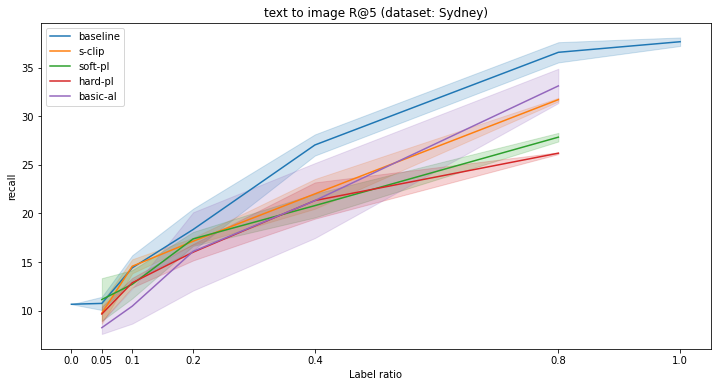

In [21]:
metric = 'text_to_image_R@5'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)